In [16]:
import random
import numpy as np
import scipy.stats as stats 
from matplotlib import pyplot as plt
import math
import scipy.integrate as integrate
from scipy.integrate import odeint
import datetime as dt
from queue import PriorityQueue
from dataclasses import dataclass
from functools import total_ordering
import pandas as pd
from queue import PriorityQueue
from scipy.optimize import curve_fit
import math

plt.rcParams.update({'font.size': 20})

# Parameters

In [17]:
b = 5.12e-8 # 10^-8 mL/day
f = 1.8e-6  # 10^-6 mL/day
p = 0.004 # 1/day
k = 4    # eclipse period, 1/day
d = 1.4  # 1/day
m = 51.4 # 1/day
c = 10   # virus clearance rate, 1/day

resolution = 1000
max_days = 20

# Viral load equation

In [18]:
def dP_dt(P, t):
    return [-b*P[4]*P[0]-f*P[3]*P[0]+p*P[1], f*P[3]*P[0] - p*P[1], b*P[4]*P[0]-k*P[2], k*P[2]-d*P[3], m*P[3]-c*P[4]]

In [19]:
ts = np.linspace(0, max_days, resolution)
P0 = [8.9e7, 0.0, 0.0, 1.0, 0.0]
Ps = odeint(dP_dt, P0, ts)

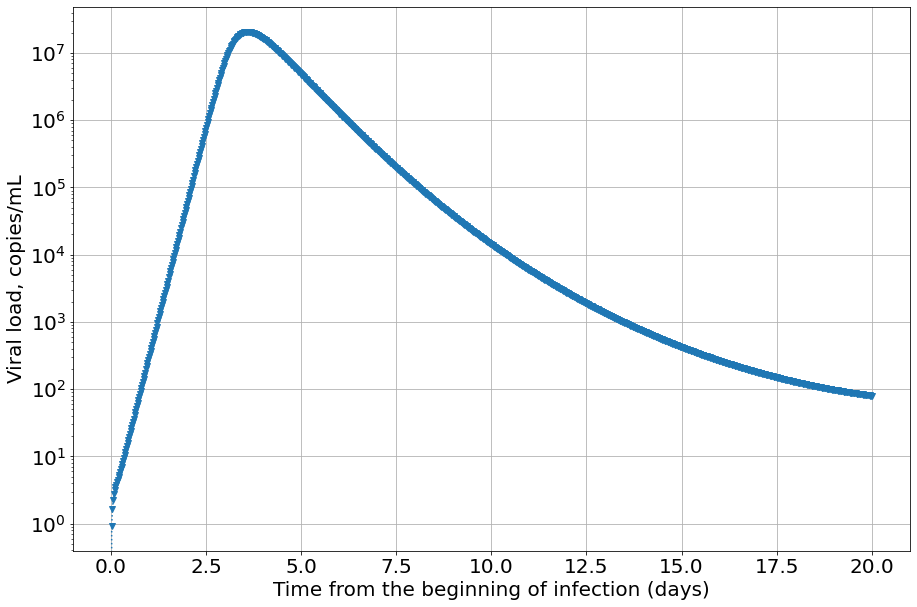

In [20]:
plt.figure(figsize=(15, 10))
plt.yscale("log")
# plt.plot(ts, Ps[:,0], "+:", label="T")
# plt.plot(ts, Ps[:,1], "x:", label="R")
# plt.plot(ts, Ps[:,2], "o:", label="E")
# plt.plot(ts, Ps[:,3], "*:", label="I")
plt.plot(ts, Ps[:,4], "v:", label="V")
plt.xlabel("Time from the beginning of infection (days)")
plt.ylabel("Viral load, copies/mL")
plt.grid()
#plt.legend()
viral_load = Ps[:,4]

In [21]:
scale = 10

In [22]:
from scipy.stats import lognorm
lognorm.rvs(1, loc=0, scale=10)

16.93466422198198

In [23]:
def prob_transmission(v_t, theta, h, k_m):
    vth = math.pow(v_t, h)
    return 1 - math.exp(-theta * (vth / (vth + math.pow(k_m, h))))
#    return theta * (vth / (vth + math.pow(k_m, h)))

In [24]:
inf_function = lambda xx: np.fromiter(map(lambda x: prob_transmission(x, 0.2, 0.51, 8.9 * math.pow(10, 6)), xx), dtype=float)

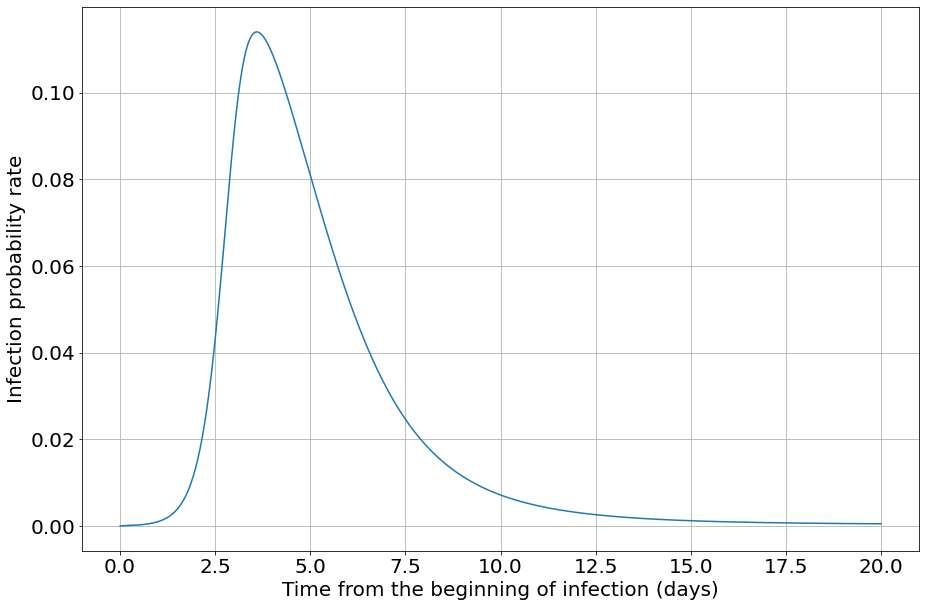

In [25]:
inf = inf_function(viral_load)
plt.figure(figsize=(15, 10))
plt.xlabel("Time from the beginning of infection (days)")
plt.ylabel("Infection probability rate")
plt.grid()
plt.plot(ts, inf)

## Lognormal PDF as model function

In [26]:
def logn(x, s, m, k):
    if (x == 0): 
        return 0
    m1 = 1.0 / (x * s * math.sqrt(2 * math.pi))
    exp = -(math.pow(math.log(x) - m, 2) / math.pow(2 * s, 2))
    return k * m1 * math.exp(exp)

In [27]:
def loglog(x, a, b, s):
    #print(x, l, k, s)
    if x < 0:
        return 0
    else: 
        #return s * (k / l) * math.pow(x / l, k - 1) * math.exp(-math.pow(x / l, k))
        return s * (((b / a) * math.pow(x / a, b - 1)) / math.pow(1 + math.pow(x / a, b), 2))

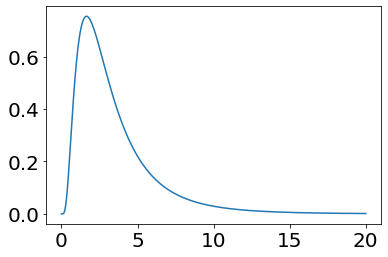

In [28]:
vlogn = np.vectorize(logn, otypes=[float])
res = vlogn(ts, 0.5, 1, 2)
plt.plot(ts, res)

In [29]:
popt, pcov = curve_fit(vlogn, ts, inf, p0 = [0.5, 1, 2])
popt

array([0.25771557, 1.49148178, 0.29309045])

In [30]:
# lopt, lcov = curve_fit(vloglog, ts, inf, p0 = [1, 1, 1], bounds = ([0.01, 1, 0.01], [50, 50, 50]))
# lopt

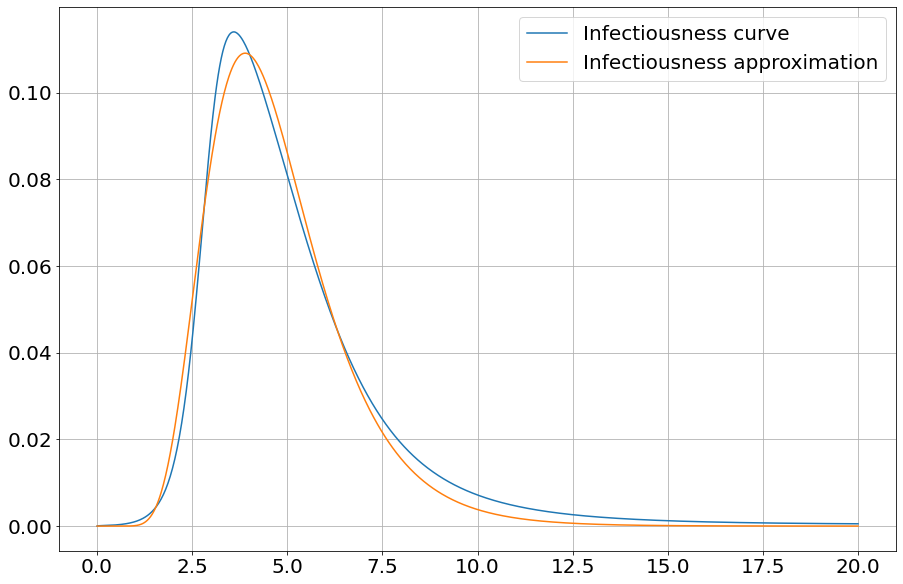

In [31]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.plot(ts, inf, label="Infectiousness curve")
plt.plot(ts, vlogn(ts, *popt), label="Infectiousness approximation")
plt.legend()
plt.show()

In [32]:
# plt.figure(figsize=(15, 10))
# plt.grid()
# plt.plot(ts, inf, label="Infectiousness curve")
# plt.plot(ts, vloglog(ts, *lopt), label="Infectiousness approximation")
# plt.legend()
# plt.show()

In [33]:
lam = 1

In [34]:
max_inf = np.max(inf)
max_inf

0.11401366149635628

In [35]:
t = 0; t_max = 20
while t < t_max:
    r = random.uniform(0, 1)
    t = t - math.log(r) / lam
    if t < t_max:
        x_inf = int(t * (resolution / max_days))
        s = random.uniform(0, 1)
        rate = inf[x_inf]
#        print("t: {}, rate: {}, s: {}".format(x_inf, rate, s))
        if s < (rate / max_inf):
            print(t)

3.2530239043474003
4.010647169752027
7.217779234483447


# Antibody titer decay

In [36]:
titer_half_life = 108 # days
titer_decay_n50 = 0.2 # e.g. 20% of titer still gives 50% of protection

In [37]:
ef = np.fromiter([99, 95, 90, 80, 70, 60, 55], dtype='float')
std10 = 0.44
hl = 108
dr = -math.log(2)/hl
std = math.log(math.pow(10, std10))
#stats.norm.ppf((1 - 95 / 100), loc = 0, scale=std)
dr

-0.0064180294496291234

In [38]:
def eff_function(initial_eff, std, num_days):
    threshold = stats.norm.ppf((1 - initial_eff / 100), loc = 0, scale=std)
    days = np.arange(1, num_days)
    #mn = dr * days
    return np.fromiter(map(lambda x: (1 - stats.norm.cdf(threshold, loc=dr * x, scale = std)), days), dtype='float')

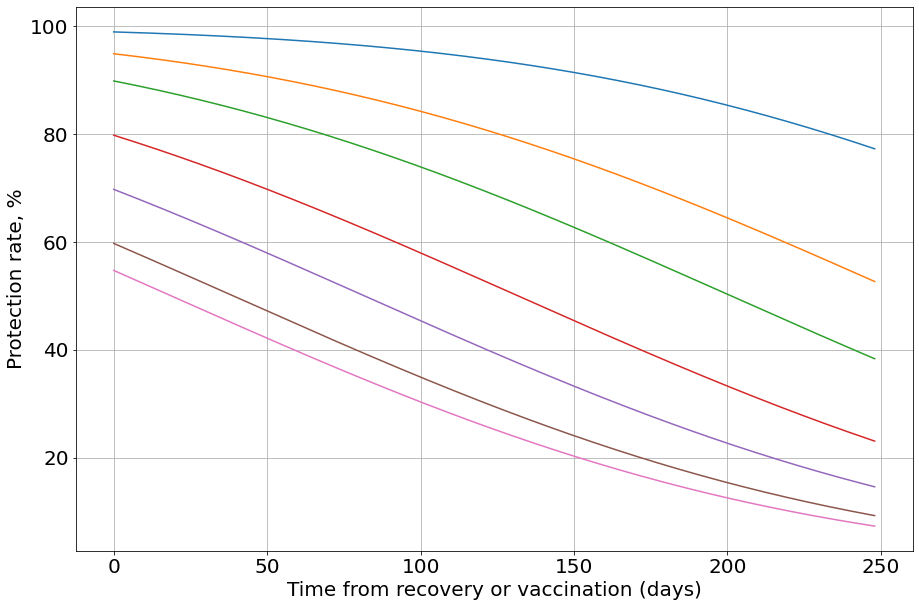

In [39]:
plt.figure(figsize=(15, 10))
for r_eff in ef:

    plt.plot(eff_function(r_eff, std, 250) * 100)
plt.xlabel("Time from recovery or vaccination (days)")
plt.ylabel("Protection rate, %")
plt.grid()
plt.show()

## Immunity decay curve approximation

In [40]:
def decay_approx(x, k, l, x0):
    try:
        ex = math.exp(-k * (x - x0))
    except OverflowError:
        ex = float('inf')
    return l / (1 + ex)

In [41]:
vdecay_approx = np.vectorize(decay_approx)

In [42]:
xdata = eff_function(95, std, 250)

In [43]:
nts = np.arange(1, 250)

In [44]:
popt, pcov = curve_fit(vdecay_approx, nts, xdata, p0 = [0.5, 1, 100])
popt

array([-9.84910262e-03,  1.02976028e+00,  2.53502854e+02])

99.0 [-1.10157870e-02  1.01150419e+00  3.54908759e+02]
95.0 [-9.84910262e-03  1.02976028e+00  2.53502854e+02]
90.0 [-9.77555285e-03  1.03320181e+00  1.95573648e+02]
80.0 [-1.01462280e-02  1.00975733e+00  1.30783778e+02]
70.0 [-1.06834250e-02  9.60587356e-01  9.09227156e+01]
60.0 [-1.12938032e-02  8.91864887e-01  6.21221787e+01]
55.0 [-1.16237125e-02  8.50915709e-01  5.01987080e+01]


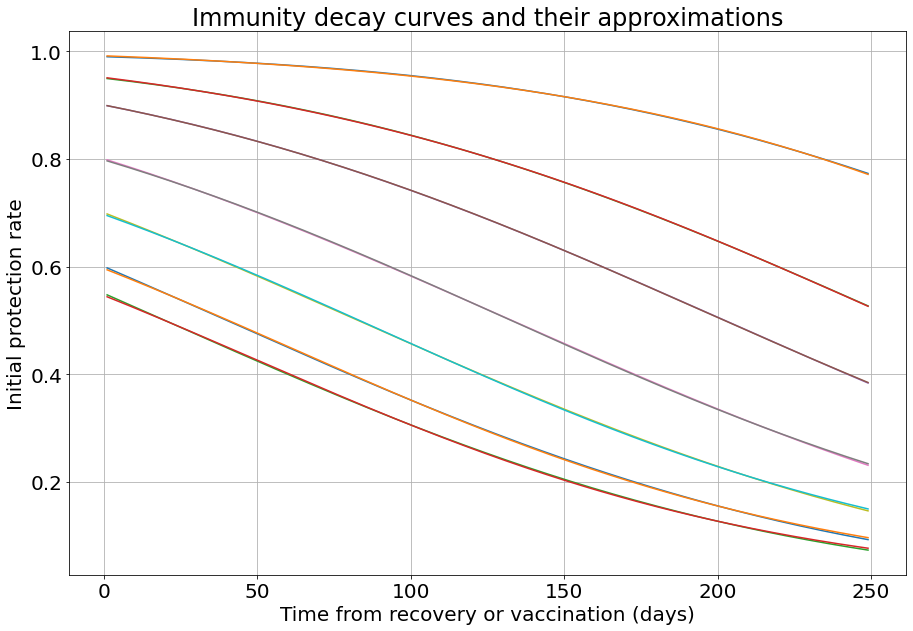

In [45]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title("Immunity decay curves and their approximations")
plt.xlabel("Time from recovery or vaccination (days)")
plt.ylabel("Initial protection rate")
nts = np.arange(1, 250)
for r_eff in ef:
    xdata = eff_function(r_eff, std, 250)
    popt, pcov = curve_fit(vdecay_approx, nts, xdata, p0 = [-0.5, 1, 100])
    print(r_eff, popt)
    plt.plot(nts, xdata, label="Decay curve {}%".format(r_eff))
    plt.plot(nts, vdecay_approx(nts, *popt), label="Decay curve approximation {}%".format(r_eff))
plt.show()

## The components

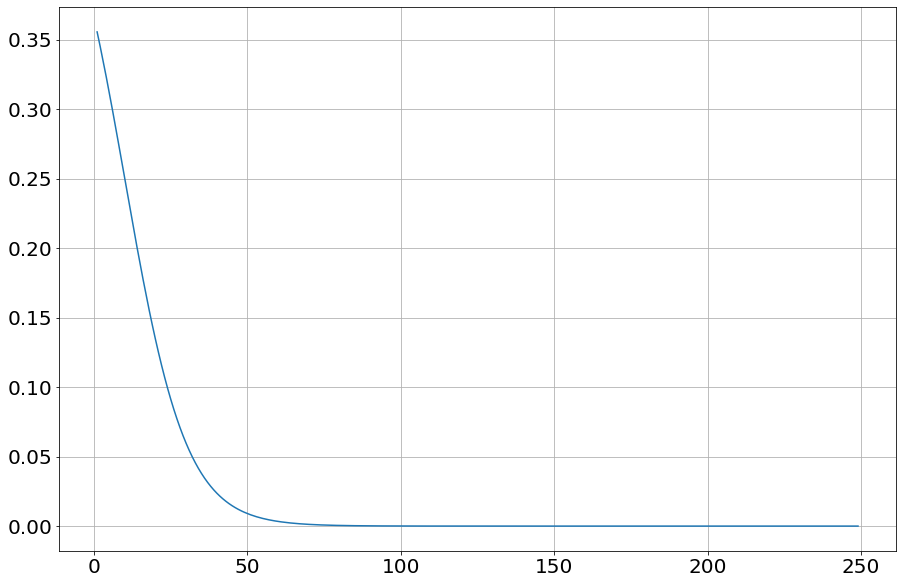

In [152]:
popt = [-1e-01, 0.5, 10]
plt.figure(figsize=(15, 10))
plt.grid()
plt.plot(nts, vdecay_approx(nts, *popt), label="Decay curve approximation {}%".format(r_eff))
plt.show()

# The epidemic simulation

In [153]:
N = 1000
initial_infected = 2
start_date = dt.date(2021, 12, 1)
contact_matrix = pd.read_csv('switzerland-contact.csv', header=None)
contact_matrix[0].sum() # check row or column

5.649117846175628

In [154]:
@dataclass
@total_ordering
class Event:
    node: int
    time: float
    action: str

    def __le__(self, other):
        return self.time < other.time

In [155]:
# population distribution
pyramid = pd.read_csv('Switzerland-2019.csv')
pyramid['M+F'] = pyramid['M'] + pyramid['F']
hist = pyramid['M+F'].to_numpy()
norm = np.linalg.norm(hist, ord=1)
nhist = hist / norm
idx = np.arange(0, nhist.shape[0])
samples = np.random.choice(idx, 1000, p = nhist)
age_bins = pyramid['Age'].to_numpy()

In [156]:
ndtypes = np.dtype([
    ('exp_time', float), ('susceptibility', float), ('age_group', int)
])
ndata = np.empty(0, dtype = ndtypes)
nodes = pd.DataFrame(ndata)

In [157]:
rows_list = []
nodelist = []
num_bins = age_bins.size
matrix_rows = contact_matrix.shape[0]
age_index = np.arange(0, num_bins)
for i in range(0, N):
    age_group = np.random.choice(age_index, p = nhist)
    age_group = matrix_rows - 1 if age_group >= matrix_rows else age_group
    rows_list.append({'exp_time': -1, 'susceptibility': 1.0, 'age_group': age_group})
    nodelist.append(i)
nodes = pd.DataFrame(rows_list)
infected = random.sample(nodelist, initial_infected)
nodes

exp_time  susceptibility  age_group
0          -1             1.0         10
1          -1             1.0          8
2          -1             1.0         13
3          -1             1.0          9
4          -1             1.0         12
..        ...             ...        ...
995        -1             1.0         15
996        -1             1.0          9
997        -1             1.0         14
998        -1             1.0          9
999        -1             1.0          7

[1000 rows x 3 columns]

In [158]:
def exponential_variate(v):
    U = random.random()
    return -math.log(U) / v

In [159]:
def select_contact(G):
    # todo age contact matrices
    contact = random.randint(0, N-1)
    return contact

In [160]:
infected

[714, 244]

In [161]:
def sim_infect(Q, G, res, event, beta, tt_max):
    # generating infection times
    # node = nodes.at[event.node]
    t = 0; t_max = 20
    inf_times = []
    while t < t_max:
        U = random.uniform(0, 1)
        t = t - math.log(U) / beta
        if t < t_max:
            x_inf = int(t * (resolution / max_days))
            s = random.uniform(0, 1)
            rate = inf[x_inf]

            if s < (rate / max_inf):
                inf_times.append(t)

    for itime in inf_times:
        if event.time + itime > tt_max:
            return
        target = select_contact(G)
        U = random.uniform(0, 1)
        
        # here, calculate the susceptibility
        # if no last event time, s = 1.0
        # else, it rises from the corresponding logistic curve, 0.0 to 1.0
        
        susceptibility = 0.0
        if G.loc[(target, 'exp_time')] == -1:
            susceptibility = 1.0
        else:
            delta_t = event.time + itime - G.loc[(target, 'exp_time')]
            susceptibility = 1 - decay_approx(delta_t, *popt)
            print(delta_t, susceptibility)

        G.loc[(target, 'exp_time')] = event.time + itime    
        if U < susceptibility:
            event = Event(node = target, time = event.time + itime, action = 'infect')
            # print(event.time)
            #G.loc[(target, 'susceptibility')] = 0
            ## todo removal process / calculated susceptibility
            Q.put(event)
    # print('=======')

def simulate(G, t_max, beta):
    print("sim~")
    Q = PriorityQueue()
    res = [{'time': 0, 'cases': 0}]
    # initial exposure events
    for u in infected:
        event = Event(node = u, time = 0, action = 'infect')
        nodes.at[event.node, 'exp_time'] = event.time
        Q.put(event)

    # main loop
    last_day = 0
    cases_by_day = {}
    while not Q.empty():
        event = Q.get()
        #print(event.time)
        if event.time > t_max:
            break
        if event.action == 'infect':
            day = int(event.time)
            cases_by_day[day] = cases_by_day.get(day, 0) + 1
            sim_infect(Q, G, res, event, beta, t_max)
            if day > last_day:
                #print(cases_by_day[last_day])
                res.append({'time': last_day + 1, 'cases': cases_by_day[last_day]})
                last_day = day
    # elif event.action == 'remove':
        #     sim_remove(Q, G, res, event)

    return pd.DataFrame(res)

In [162]:
res = simulate(nodes, 100, 1.0)
res

sim~
9.955714039563485 0.7494464263992884
-6.09024028076346 0.5833620792680423
11.787037316240117 0.7722787087281605
3.085445860543242 0.6668546937063846
3.6246420730499906 0.672901894522155
27.234941380421155 0.9242891780624638
7.499861828141849 0.7189100491183835
4.3974986606980195 0.6817447927645685
-14.061246361604798 0.5413534265422006
13.76163995341295 0.7964737865539939
-6.195074956309469 0.5826364018810462
10.229567755000097 0.7528694709177723
-6.71466712594362 0.5791143629691491
11.610252274512536 0.7700847737922301
-17.413735369762517 0.5302878466225809
10.981096413927524 0.7622538776072267
52.930384702784416 0.9932604120803621
7.601336155363079 0.7201596392219882
26.17301839174201 0.9172113421207099
-14.930710414439712 0.5381726777799593
-10.814084879876503 0.5554584966784669
-14.70532182872699 0.5389749882718022
0.4909116954282844 0.639351042782609
4.218444126689285 0.6796785516637154
9.790562665257156 0.7473821290069198
1.69449569329376 0.6517643485428996
13.55068395514185

-29.553269688021963 0.5093962420082545
-8.344628974612242 0.5688537364814488
-7.773805032055186 0.5723134451731323
5.160111534045562 0.6906553303132882
-2.7273931809240253 0.6093943433217468
4.528684420554015 0.6832650825850876
28.760339427530017 0.9335774562033585
18.32683616211132 0.848461033585765
4.435611784006483 0.6821859237048628
-9.561924826387965 0.5619398496870075
4.3444613922486965 0.6811316899633104
10.05717165651717 0.7507146437598962
9.206027777009794 0.7400805576119178
0.3841726780317103 0.638280708727462
-7.96541262366037 0.5711363082624288
5.3736788719000685 0.6931807997929356
-12.119892540207921 0.5493395023615859
18.078919061555048 0.8458300502233557
1.1842656818033106 0.6464259156566476
5.842271562631225 0.6987643563338939
23.70453626286234 0.8987267169165799
-1.5522788680387478 0.6197677420445702
-7.135111114486008 0.5763544314329138
-13.253253280317345 0.5445235671658675
-5.248347396246658 0.5893753412041206
13.592978806976095 0.7944352300776347
-4.133921204465189

15.229055502957607 0.8139134648829791
3.7471023699887382 0.6742896677231198
-8.330699443556817 0.5689364807242291
-17.97629378720533 0.5287262071595497
4.481324884726362 0.6827156203377472
14.506339705776519 0.8053949777787064
-6.103707985558607 0.5832685697186004
16.705523166169762 0.8308134105498091
-1.564649905206835 0.6196551040379651
2.9372433487668417 0.6652111518492279
-14.911735384608974 0.5382396344497783
2.4318285005942357 0.6596688479660918
16.277395052547668 0.8259883626747071
-7.404985473870418 0.5746248104096671
3.9121457169922778 0.6761681539510984
15.36813201850574 0.8155353881801081
-0.21597259024553495 0.632358195315087
-9.95930232276676 0.5598154420866093
17.364131941735167 0.83810551157528
4.044146360271931 0.6776771705746251
15.470904857131295 0.8167301491942479
12.960717453006538 0.7867409713176463
20.03767558865031 0.8658993402540476
31.303319929482157 0.9469082607065873
-20.661259498060836 0.522263176862316
-19.43578229486303 0.5250204507249704
-1.65458034178818

19.074359118518622 0.8562375922891916
-18.736815926147948 0.526735008206384
13.090671776095583 0.788328776726574
6.121099379182212 0.702112664160061
3.5830925610823527 0.6724322222461155
-6.332352145610358 0.5816938255670268
-5.3661121605784246 0.588514222177249
-3.537356294223777 0.602630156562397
15.44380379706778 0.8164154080283834
-6.716742610736674 0.5791005420099302
-0.7518715204412061 0.6272089417392552
-9.858743038666177 0.5603470126960595
-21.02756182393742 0.5214968540893821
7.35765605065108 0.7171615432497431
2.3337561367819717 0.6586048856199139
4.662384119339315 0.6848199927381222
10.590413479181926 0.7573780253712221
14.936837572052461 0.8104869233198326
26.749367390699604 0.9211164536316838
12.249855072816345 0.7780051564169194
2.1165025971876332 0.6562615609843824
-15.801734282149056 0.5352126882286831
2.79262692595033 0.6636153217411738
0.832594172391147 0.6428112441306917
-26.76258979665029 0.5123461810322196
-15.830825564746618 0.5351175831716057
-5.522622542877592 0

4.183060902414276 0.6792714591301081
-10.734564257321928 0.5558518054876505
-0.4330888952426193 0.6302560231100285
2.9347014074040274 0.6651830336733212
-7.412457131447269 0.5745773874634126
8.042573025684668 0.7256099888230021
20.896135743625443 0.8741544740779624
-4.746006600207764 0.59312217162127
6.631892603401091 0.7082921969720632
1.3534585340137681 0.6481839395498346
-1.3069558093479756 0.6220163783762536
-5.727678425973977 0.58591108589885
-1.8334377403920854 0.6172257547443525
7.158033444220671 0.7147126058714319
12.592780973368512 0.7822294119326483
22.202456582513776 0.8860533889132848
30.486277795005222 0.9429044450123202
48.249666714738424 0.9893233736870863
-12.413212544546973 0.5480503545994606
-1.9960474156977455 0.6157727691205694
12.123711671808366 0.7764470702961856
-8.93831088813235 0.5654041339598725
25.583834622269933 0.9130606339735117
43.485737882242326 0.9830290508242581
6.694601602646031 0.7090546388175356
1.2915333913511233 0.6475390800159764
13.6355047170763

-6.2903968743795815 0.581980978444437
11.811599711480575 0.7725832669194863
0.6435753038278733 0.6408906915900814
3.3803098257577346 0.670148718949845
22.251633879358813 0.8864854665564688
-1.5214027150371976 0.6200491854399464
4.585569506751639 0.6839259780554622
4.557658507803026 0.6836015810652304
-21.819260946242593 0.5199257848138038
-18.30091525555799 0.5278597910619679
2.8266739916691535 0.6639903163133227
6.58913080577296 0.7077727377630506
-1.8634088642326674 0.6169570019817683
6.060066093145323 0.7013781719767173
17.69736827331198 0.8417319807268834
-0.7964097104502841 0.6267869827857753
-14.015109396648619 0.5415287761655073
7.844218000145247 0.7231566044751844
10.371244987884417 0.7546400294424294
-0.7940230335530885 0.6268095709333249
-9.50827400784464 0.5622315832891083
-0.632098515099166 0.6283482629508146
5.147066748053724 0.6905014825290083
10.799176067447362 0.759984387365043
-0.06596776778822999 0.6338231974820828
14.56987546054841 0.8061496477444513
22.1024285634459

8.804082362991096 0.7350688210100398
15.033489461479626 0.8116230113067742
-0.17901760089378627 0.6327181568440651
-11.51093345764788 0.5521145491404414
1.5054904657568429 0.6497740226284633
9.557098830356132 0.7444646402033553
14.663805931372991 0.8072633671764531
7.19071767624564 0.7151131111167135
2.929742271186136 0.6651281842095049
10.245598025265089 0.7530698210118139
-0.3950998059298527 0.6306222772782457
2.677966846560075 0.6623557056884133
5.5555976808814975 0.6953417304744581
6.778810200988126 0.7100797115959705
4.59094842087962 0.6839885222990343
-2.5248271315493085 0.6111353325938853
1.0430129759360938 0.644967608372187
7.660477024051502 0.7208886228923194
9.521702080461651 0.7440224155335082
10.167970765004526 0.7520995851977301
-9.55158125356106 0.561996002746076
1.147084213750908 0.6460412175624848
1.5024082465173265 0.649741689216333
-19.505147502563148 0.5248560943313605
-2.6349530413872273 0.6101863909704619
7.988716112778292 0.7249433617562084
-2.271051242099844 0.61

-13.866592460313797 0.5420978345195939
-29.646747475783577 0.5093104451933368
4.499004100480946 0.6829206518339208
11.742214874988612 0.7717227675540819
-1.1091592865457613 0.6238500852915109
5.5772642832787795 0.69559967808942
5.492301068060236 0.6945888663228169
-13.35929063803571 0.5440953615896389
0.004442567904874295 0.6345143882609703
-8.264166592560827 0.5693328523202938
-6.7239663658051185 0.5790524532478272
5.825436734448978 0.6985627943922006
-19.239816864421208 0.5254903577272673
-4.526608920595649 0.5947961949516547
2.289231304685636 0.6581231019046896
0.947101336935674 0.6439823212275159
6.8852699078508905 0.7113776174036521
-4.3343232999434775 0.5962822253722085
-1.3334779056573964 0.621771903650298
-6.901194627247321 0.5778800651296899
3.327872905411674 0.6695606212267136
5.325316205046832 0.6926078094961311
25.61196037251861 0.9132624547774879
-1.7835802161962349 0.6176737783728224
-7.8488241952372775 0.5718506502878642
-3.8745106904994273 0.5999074954761248
-16.0576874

-8.63000355061154 0.5671768596426809
0.121592140033016 0.6356693868722447
4.388625932310198 0.6816421633031859
7.880816399594281 0.723608898506222
2.8778235163077284 0.6645545031361355
7.7185101309841855 0.7216044402939278
23.72457839118743 0.8988884821106129
26.469629686868203 0.9192400821952121
1.9152817323547708 0.6541081178588537
1.4732466998857205 0.6494359736555336
-20.337655622087524 0.522961779050912
-6.756297381749562 0.5788375155918217
-14.95335141409268 0.5380929258349771
-1.1441143042804853 0.6235246883125671
13.212172615723738 0.7898104397216825
20.565962686828428 0.871019775348984
30.974754269966546 0.9453287807080846
0.31078652235172655 0.6375477763398147
-4.150841138858894 0.597716698194416
8.988187244482603 0.7373631197139512
9.138553455739391 0.7392385723316728
-2.6923568256075328 0.6096940593520149
-16.104281599385367 0.5342351448670859
-2.3116837113172153 0.6129884994400125
-5.3673404986045625 0.588505274742302
5.280534703053405 0.6920778148669087
5.575482705209602 

-5.094184855478247 0.5905124947765288
7.24804893890898 0.7158160756569296
0.8585283294801798 0.6430759743947085
-20.339158148043147 0.5229584876479247
-0.9781475865588973 0.6250747833451723
-2.4708914378859745 0.6116022143331805
5.145550607926161 0.690483604549518
9.17300468246981 0.7396684461675134
8.88868298023111 0.7361228165436771
-3.838993788618339 0.600191736250471
2.2617914263325645 0.6578265791259812
9.23882487670273 0.7404899022091449
10.732577490337242 0.7591531254904477
1.7302864521725567 0.6521429209258308
7.4731027097222125 0.7185807881124107
-11.657710236023178 0.5514333250173404
0.304212365280236 0.6374822357734052
-0.49646008868309366 0.6296465413124899
4.521023773035893 0.6831761570019217
-1.2192810212382028 0.6228269077867966
6.0240040601402285 0.7009445998010662
4.694948455521605 0.6851995382430298
-15.94919424741849 0.5347330570753763
21.73175194655839 0.8818592337323994
-2.8580670566387383 0.6082817075233066
-4.2882938730091595 0.596640572390313
-12.761991965653252

-6.207502209540564 0.5825507157690646
-3.2641479681192322 0.6048765091185406
-5.963296771657923 0.5842476092056192
-3.172503762051747 0.6056380614871022
-6.431184366477247 0.5810205914498268
13.043226130109176 0.7877494369622169
-6.280703074854394 0.5820474406319116
-1.9243321073234796 0.6164120202225207
-8.151860790952732 0.570006254263988
1.1674823040228546 0.6462521929147274
6.4003750685810346 0.7054843226621752
6.389946156479191 0.7053581062729433
3.24975534379481 0.6686863467304853
-1.8750370379440895 0.6168528468053442
7.074019105621929 0.7136839655345076
2.8793818321894236 0.6645717071108189
-1.3268631817164902 0.6218328455889358
2.7928540768612464 0.6636178221231501
6.004549783826128 0.7007108291198206
-3.8909374490875024 0.5997762373622686
-0.6595908003020554 0.6280861573362055
-5.502613968566223 0.5875242587717959
0.742307351022589 0.6418919133278091
0.7531400529246355 0.6420020267477186
-4.310020519764599 0.5964713004713291
9.688252500875912 0.7461034718307936
11.59430518659

14.236505253571039 0.8021782288401087
21.546570582163653 0.8801802596614391
-21.44621990282714 0.5206518552678406
-8.177771064729406 0.5698504081991261
-4.033538694019924 0.5986422211781605
6.275122048943587 0.7039700098092453
16.265832894942896 0.8258571651798964
-0.31144464172999875 0.6314311430417103
-5.754419613499188 0.5857209902067557
-17.062295571759222 0.5313033816829861
-0.49697694783051105 0.6296415779711982
-6.474354716634473 0.5807279271043072
1.289385882851704 0.6475167461546478
18.29665142026601 0.848142060605561
-5.23270814142527 0.5894901901333829
-0.2807601994628328 0.6317286389081955
-1.6581059604689088 0.6188065366775832
5.195484305091256 0.6910727496712479
15.041096524015913 0.8117123138066601
-4.860729918037556 0.5922559408087489
2.9056430414752583 0.6648617713836493
-0.2807892032735495 0.6317283575024818
4.0355666911320185 0.6775789122595404
13.225135787133716 0.7899683540520634
-3.8993689251254082 0.5997089158953275
3.4288801988910578 0.6706943316171927
2.8236728

-6.594859973186601 0.5799155038774891
-3.160708707421186 0.6057363704789884
-6.142144719841831 0.5830021557351941
3.9486479245753614 0.6765848599501948
1.7648585408134068 0.6525091069206472
-5.595971213900938 0.5868522325387824
3.7377300286703132 0.6741832731176737
-5.316873886179643 0.5888734674127183
3.5652916586277854 0.6722311872874751
4.6619452897853435 0.6848148802655668
10.786000573681811 0.7598199520781947
5.09835794162403 0.689927442860423
15.729933479105881 0.8197267936340201
-0.44737176838528825 0.6301184936002443
-19.90037420422128 0.5239389919927855
-8.1880959901411 0.5697883864780746
3.8820845155979242 0.6758253149487363
-21.882975181823838 0.5198042453202609
-4.678263500385363 0.5936366114471918
9.13362987836934 0.7391771423050089
-1.1333667434137098 0.6236246763902326
-27.501691201024386 0.5114867867848588
-6.429933194109111 0.5810290862583178
-1.2673736040748125 0.6223818559778864
13.546912278125134 0.7938773626422994
-14.58782954977842 0.5393993182386602
2.82925303612

2.81961217258565 0.663912501226099
14.334314156420966 0.8033463802127653
-0.6714877395290131 0.6279728432853432
9.19925926754754 0.7399960855791066
-1.692545630816042 0.6184948759648665
-17.203965263918796 0.5308902390760428
-23.726574265939718 0.5165805011871912
8.0066836049945 0.7251657192458532
5.636575231605164 0.6963064140282459
-10.28648923766314 0.5581138155068976
-0.8162062865563158 0.6265997251338304
2.6382795522100366 0.6619208893372677
-2.197445768347194 0.6139907017147143
7.233743071069952 0.7156406128979185
5.7965337317546215 0.698216904178272
-9.601560045113793 0.5617250826453642
-22.01525070681607 0.5195541860033818
4.878388439110616 0.6873435184524341
-6.716041361104928 0.5791052115152778
-2.8375510104760338 0.6084558501435611
-2.0241113866972924 0.6155232830368023
-2.182741157829099 0.6141201583711204
2.3210637164353756 0.6584674663933214
13.787728429067833 0.7967885467512776
1.4860957936659815 0.6495706332153263
-1.133408924561678 0.6236242838589825
2.960948955334395 

-3.9174133332988816 0.5995649542035415
4.325875459730156 0.6809170508516245
-3.853704914750274 0.6000739300568512
0.5826475400032649 0.6402749821382994
-24.129913589913684 0.5159459551954768
-21.080862432600924 0.5213874674587166
0.5034814705176842 0.6394774212755572
-5.700159448264316 0.5861070593423439
1.6299135285736952 0.6510825856306558
4.968586026801759 0.6884013566299956
1.7373860646748867 0.6522180793330565
9.50346075667342 0.7437945343769641
-0.8740512027062195 0.6260536130140352
1.0831140778328745 0.6453807421155002
2.146568766425844 0.6565847323646725
8.780339232135795 0.7347731116390485
11.788944504551075 0.7723023590578985
17.062122945603498 0.8347818379158799
11.723095641388198 0.7714855618945096
12.812572323670452 0.7849272121077311
30.138555999698163 0.9411220844228267
-4.968912016549005 0.5914448239470214
5.461352138436212 0.6942211362011652
9.491424230566473 0.7436441727649867
9.589469328136595 0.7448690871986403
-2.265484587763879 0.6133930485214282
1.293686900522104

-3.310614737945137 0.6044919196031616
2.8068466805812946 0.6637718846601468
2.485818560133829 0.6602561864501095
-26.666258586634896 0.512462709215694
-8.43262976948921 0.5683329214378992
2.9305668216288154 0.6651373033331749
3.2857839487407503 0.6690892963739322
-1.9205352486855247 0.6164459328385352
0.42252485865373757 0.6386647033255528
-10.076333461129089 0.5592018981942628
3.106425839114536 0.6670880172402082
3.7516732915928444 0.6743415676801586
-4.663364511817591 0.5937500470446478
-3.0195693360197566 0.606917926231647
18.205223089821857 0.8471736002791843
1.086597264904107 0.6454166597430175
4.087603084034221 0.6781752310346552
5.77018356727978 0.6979017448465421
6.7634085109169035 0.7098921224919181
-8.127823755022987 0.5701510933040939
0.2781114877804072 0.6372222163905067
9.934533508467595 0.749181671778544
7.619250247205457 0.7203803986025998
15.569707776306643 0.8178756736889826
-6.568478553496149 0.580092794399645
4.526250672874852 0.6832368294199975
-1.0069191565853544 0

11.874166940050316 0.7733587536918437
-0.47354670487116834 0.6298667000736329
4.281488997766651 0.6804049014719131
8.853150853117384 0.7356800776107763
17.176780787982153 0.8360477547084437
-4.770217078465961 0.5929388471251286
-28.59181762821919 0.510324919147173
1.167290401043637 0.6462502072490621
1.3653405388847233 0.6483078595944572
4.121176344157114 0.6785604426739329
-2.933121398481603 0.6076463622096107
-6.898746359074536 0.5778961637164448
7.59929759053329 0.7201345205141456
-4.1568198205809 0.5976697026015176
-8.796584174609556 0.5662140566715007
-4.908277949309856 0.5918987562198674
-3.2176411181419695 0.6052624704865315
-2.956929044626193 0.6074453932348642
-2.148866627672504 0.6144187772780816
-7.42949005316725 0.574469371654196
-4.1181348435419025 0.5979740899184898
-1.953739779225664 0.6161495910864568
4.77213729857197 0.6861004708462177
-4.576761219012461 0.5944115068275733
3.450570382487271 0.6709382591345295
0.9174067413952116 0.6436780825201897
1.4637287235349419 0.6

-7.4193097611029515 0.5745339153679556
-4.413653084388272 0.5956670058817637
10.80182201421448 0.7600174087711429
-6.18274968058391 0.5827214552970328
-3.825256526916718 0.6003018375783511
12.151270412653567 0.7767876495164756
-12.646818401563088 0.5470452707215369
-5.713911178202707 0.5860090836548315
-1.898924636217437 0.6166390845594287
6.340707155832526 0.7047625074758332
-4.186412745516151 0.5974373386248498
0.3518708181375345 0.6379578020119051
-17.697645712682004 0.5294900393696174
4.408845088684174 0.6818760713469403
15.029332135093782 0.8115741996291916
17.309777676874546 0.8375099001435472
20.866275292776834 0.8738730657871498
-4.288244784360877 0.5966409550946894
-12.442651262624125 0.5479226462939687
-3.9816043288249716 0.5990540926193583
4.080948597588652 0.6780989230808088
14.180952802039208 0.801513688714522
-21.340502022452554 0.5208621825561924
-3.884582484003502 0.599827001389915
1.1162832776846017 0.6457229856932238
4.275069078187762 0.6803308780418917
8.674227806851

18.954723609721682 0.8550090917491681
27.72003694251695 0.927353336533715
-3.1379535257076654 0.6059262186684204
0.47493218034785656 0.6391904837090908
4.635249925890832 0.6845039828558148
-1.1607243969726113 0.6233702660938069
-5.6894009750482155 0.5861837708562447
6.604798122580732 0.7079630169523968
8.443560349646368 0.7305836853102168
0.04344982459861768 0.6348982769662324
-10.250325725615149 0.558299807005211
7.07367409890459 0.7136797439638426
-3.736379661633059 0.6010163570544125
1.037865679626286 0.6449146296899615
-0.3518725914294052 0.6310398412073787
-8.795290611542143 0.5662214879566088
11.415295214658137 0.7676617187772934
17.15950931633357 0.8358573811162618
-26.99026366662757 0.512074978074855
5.869423477133523 0.6990895903046727
-3.08953144592671 0.6063310368191277
-1.4322603634601805 0.620864274658472
4.189109335310427 0.6793410190015264
-4.670520545850181 0.5936955503598255
2.6770340342020873 0.6623454787849581
1.1336322177853049 0.6459021828173659
-4.380739334600577 

-3.7921862310247576 0.6005672608113519
-15.542450256355636 0.5360709089396124
-8.136113384235117 0.5701011144988981
-6.745162112675345 0.5789114895495586
-2.789569143414404 0.6088639160719007
0.37527241853247517 0.6381916903761813
-31.748905023136402 0.5075720038880349
-6.020763213195082 0.5838458101724414
10.52476219040284 0.7565580225176106
14.481134705858125 0.8050953005852078
-24.877074214040725 0.5148320114054341
6.926204282970694 0.7118772421078281
19.227047566915353 0.8577964489117709
-4.152326583411167 0.5977050202183076
3.067918914643741 0.6666598969603372
5.810612478728913 0.6983853626491899
11.181168912970328 0.7647474694980514
-0.6819413451726959 0.6278733307604063
-1.4750459481570886 0.6204725870600019
-3.980884713970184 0.5990598086922596
3.3513837524534935 0.6698241810247478
0.4461361635623433 0.6389014339750778
10.674262276575526 0.7584250867873704
-2.195507692927748 0.6140077582476562
18.850221240962455 0.8539309232818862
-0.6017266799249157 0.6286382295011891
-1.55023

5.022934377074812 0.6890398931747497
7.147169631558043 0.7145795239540849
-1.153099125058901 0.6234411412929827
25.49007115193679 0.9123851410793774
34.06690540093101 0.9586680349445575
0.519694335763802 0.6396405317011806
-11.954533139732291 0.5500797633432357
-12.222612850429414 0.5488845770258525
5.600712936525937 0.6958789786174351
-0.6628286385119111 0.6280553115822163
-0.6083096996058259 0.6285753436428818
12.304645783920712 0.7786812367877485
-0.9729246609385669 0.6251237741883611
-5.4275223405830175 0.5880677685300704
4.6063620147618 0.6841677956743828
6.407560699155049 0.7055713007304589
1.766055951474101 0.6525217986984556
16.424430937265058 0.8276527581436272
-3.3688444810690967 0.6040114384142523
-3.2606103101090724 0.6049058316530878
7.820772958332157 0.7228669567916639
3.5899341080371983 0.6725095169944366
1.6812995937026471 0.6516249025858849
13.05634851177993 0.7879097109001201
14.947975288009204 0.8106179772571455
-16.38518093002542 0.5333501135041092
-6.44078641853528

4.483775875885598 0.6827440394450053
0.7598155184640376 0.6420699079105032
14.950180385763133 0.8106439197418129
22.380113427493455 0.8876088350036785
1.4000681996800282 0.6486703852720042
2.494535470107195 0.6603511215570728
-0.7247281700370678 0.6274665536283917
-7.6062455502094295 0.5733560679755623
-8.956038355973533 0.5653034214932027
0.7656100069506024 0.642128846498047
8.470409839232126 0.7309173140995522
-10.32565760390115 0.5579129513795642
-5.319016706348165 0.5888578095182717
-0.12653745518014858 0.6332304148727166
-17.272306333559783 0.5306927663493044
12.937563417234934 0.7864577489312998
-15.830281376989639 0.5351193600457155
-5.1733240738657 0.5899273359579098
-3.7867180888547125 0.6006111988880017
-20.816023737956776 0.5219362751362983
-16.96406477262643 0.5315928674592749
6.2932006116098975 0.7041883672975274
10.623573238388879 0.7577921407068828
17.99385973498474 0.8449215597929511
10.386093387758052 0.7548255679133182
23.814120511684024 0.8996088430560477
-3.18042038

-17.213271790100606 0.5308632780618748
-7.646607360791805 0.5731037879709358
9.29570384393459 0.7411999353510993
-4.001411195889212 0.5988968594244319
-11.572438160925692 0.5518281267055758
2.3792965075461368 0.6590984699244934
-3.1207895327986392 0.6060695839759691
6.899293797836478 0.7115487506839073
-2.813288659089025 0.6086620530516791
-1.975442782641295 0.6159561818952431
2.156232531237066 0.6566886821856392
5.760439535370097 0.6977852457901882
-3.9199256452549918 0.5995449228954675
-2.7355396543161277 0.6093247394290666
-1.672772116407316 0.6186737468204802
7.231924772858093 0.7156183137737102
-0.8973219135469321 0.6258343559307649
17.38047485074695 0.8382843737578214
-18.182762405540444 0.5281722577383914
-0.9457893143356344 0.6253785083924994
-4.367550834254146 0.5960241727465243
9.444651590775031 0.7430599284599622
0.8354285984685532 0.6428401630260328
19.654898102135164 0.862109804568262
6.3589787165560665 0.704983460152848
-9.524499262941532 0.5621432321471475
0.191218546666

-12.177518242020916 0.5490838286514177
-16.475950654666327 0.5330686955686507
-6.66943872997048 0.5794160326907697
2.216735630223951 0.6573403446221043
-3.805988655016222 0.6004564182741461
-0.7190154578368535 0.627520815484886
-1.801117884802629 0.6175160484826534
-29.629491366343345 0.5093262253366173
4.955175864537708 0.6882439323180907
-4.398422129079364 0.5957848919928521
2.061558366995264 0.6556719247969272
0.5400939515640033 0.6398459290591865
-18.569744390119055 0.5271609586494573
-8.666879059455482 0.5669627123867956
8.865992357400266 0.7358400756204824
-4.810982249406251 0.5926307981042037
-4.167022883937491 0.5975895406711557
10.16127358131196 0.7520158760738727
-28.477274313884656 0.5104413802109783
-12.006061885218095 0.549848033198518
7.811964293682621 0.7227581506830061
13.032915034365786 0.7876234771744284
-5.129016948548156 0.5902545800970076
-0.46042925965582526 0.6299928456583865
2.085976858912389 0.6559338223620866
14.6475662988665 0.8070709862857878
4.8837565381139

-5.422077142210078 0.5881072836270946
-14.005257875494976 0.5415663056754609
-1.5995016061131508 0.619338170675868
-4.559319256393508 0.5945451576298939
-5.405075533057115 0.5882307517889969
11.502487565847574 0.768745842703759
-8.141792990264676 0.570066888928245
1.9661714658396932 0.6546511795786141
1.1068217693849078 0.6456253124324471
8.566875869669033 0.7321165460971695
-5.637730645151024 0.5865529516575003
15.050423069479749 0.8118217791549924
1.0939196132559061 0.6454921827676928
-6.518454500304614 0.5804298438476057
-19.327583575739283 0.525278877449948
-0.5952021053420893 0.6287005768816465
-7.930039944956846 0.5713524098656348
-0.7424400899858341 0.6272984145867901
-6.598070756996734 0.5798939482177009
-9.970717108138665 0.5597553582998622
-3.692036870936491 0.6013742666141555
3.604501635894792 0.672674153288014
9.226970012172515 0.7403419341916933
0.6720084041899668 0.6411785854693832
2.034339204691044 0.6553802732680827
-2.309561666839457 0.613007059007139
-3.79304857108724

16.79402014053197 0.831802610035764
-1.032330554590665 0.6245673037303783
-8.3128033346553 0.5690429098304985
-5.990403099241135 0.584057893765969
-5.13977771627205 0.5901750178050704
-3.667962385845506 0.601568977731754
-20.20836063470776 0.5232466981464203
3.903150275954715 0.676065531660742
-3.372992323055499 0.6039772748366699
-6.079661651258547 0.5834355881534785
3.584464158559747 0.6724477170296546
-5.368867634758942 0.5884941517980637
7.633891980859275 0.7205608667947463
1.0730546417488114 0.645277041486402
-0.3631337540998487 0.6309309783650362
2.9112276351703983 0.6649234886665312
-8.505185068995715 0.5679060149269617
14.557534764138722 0.8060031502629728
-0.44959104410675366 0.6300971326881796
-1.326229033529188 0.6218386891287062
-7.721108462276803 0.5726400104828041
-4.285677025223912 0.5966609754368397
4.974440391428978 0.6884700983919417
4.060373046558809 0.6778630727118979
11.996070782106912 0.7748683703773641
-4.2628715087345626 0.5968389242052193
-5.059876963007213 0.5

-1.198969720258404 0.6230151973412204
18.224164293150906 0.8473745200460683
-11.838105065801336 0.5506068803785521
-10.0487789834323 0.5593458622716794
8.353566140363512 0.7294659412996457
-10.3843503940439 0.5576130911688999
-6.118324869818736 0.5831671761388406
-7.1577686965545695 0.5762079648043184
7.51690243705994 0.7191197846627863
5.656019310523945 0.696538301900423
2.194048079093214 0.6570958113589818
5.014001412769247 0.6889348817843879
0.3599638431440155 0.6380386604002699
-14.60068998732794 0.5393526669357436
1.7399209922244196 0.652244919815284
1.2252887927917016 0.6468510493897666
2.874312237143428 0.6645157415955891
7.726385053618415 0.7217016112452421
18.132671794659203 0.8464026415563372
18.881427463322368 0.8542533759820317
-3.791292146398064 0.6005744440535145
6.485025154579283 0.7065096660728492
-2.8546968635285452 0.6083103002263427
-4.034360365774376 0.5986357152078245
1.496361222891096 0.6496782657216247
1.816767286587087 0.6530598493595654
-23.236462715346185 0.51

-6.745153588738475 0.5789115461974802
-2.185712261337528 0.6140939929838362
9.585718936048863 0.7448222272252016
-6.666765089517725 0.5794338948318015
6.732582450714517 0.7095168074601068
6.553997888445622 0.7073462326787463
8.308179457342845 0.7289025411806445
-0.35409215203530664 0.6310183798642064
-2.3629848002996496 0.6125404729921992
-7.357795824281929 0.5749248998875165
-4.624264134195428 0.59404824605269
11.163243651454273 0.7645241716883772
-10.020491299068887 0.5594939721745567
-9.936900899943566 0.5599335077873208
2.349268981552896 0.6587729278297034
6.507211485506687 0.7067786543221268
8.727250705907025 0.7341120752878076
18.968381971888363 0.8551496590283167
-6.730556844667021 0.5790086009414445
-5.406679421389256 0.5882190983132631
-0.5625933131925791 0.629012475026185
-2.3818048808058876 0.6123764284527213
-7.753177568504924 0.5724411298536707
3.252983332193878 0.6687224298454868
-6.118299456563236 0.5831673523382843
-2.946012197505219 0.607537512455275
-21.94687375020845

-0.5903842645123802 0.6287466277651315
-1.940545902178016 0.6162672799796228
2.9158116649247035 0.6649741571364554
7.947030550889096 0.7244276350466676
-27.577420897894015 0.5114021024743078
-7.657136443522084 0.5730380946939148
-7.199300003177967 0.575940090138689
0.38334188408050807 0.638272397818453
8.434940144715597 0.7304765862921621
14.097574717132815 0.8005148618446889
13.632367325499885 0.7949118646535684
9.719688195281122 0.7464963318544272
26.679599652717265 0.9206518210012309
-3.1107476143143487 0.6061535266093745
6.2129222847359955 0.7032193023146807
10.310759533952293 0.7538841815951046
-3.9423731517239418 0.5993660775736823
2.6143688432630228 0.6616592153389527
-0.6974519551498304 0.6277257719799404
-20.09812288344628 0.5234922750643884
-7.307766103599583 0.5752441348611016
-10.738035057956395 0.5558345881398938
-5.533900720728987 0.5872985878161654
-4.008008273328272 0.5988445314951728
-6.29823029835255 0.5819273029019575
8.555890873147227 0.7319799416613184
0.4589758679

1.3525924041485595 0.6481749088346119
-21.066444202575312 0.5214170048200772
0.25528462491327275 0.6369950638486117
-10.52549112448223 0.5568975304741968
-0.004901758349660668 0.6344225289337249
6.138775251133509 0.7023255416910092
0.8081224598811474 0.6425617119605973
6.2403666265650415 0.7035504293798545
-7.51027973195869 0.5739587937366211
-1.6024690296162163 0.6193112122484381
11.259227570959098 0.7657195786127459
18.074407566603426 0.8457819385484046
21.276471678258034 0.8777022154627587
-0.3344975879330363 0.6312079216512663
1.5385998981963738 0.65012160241761
-7.293934615151784 0.5753325895547385
-15.181093348569107 0.5372991796813131
2.8225394076940944 0.6639447545087702
2.030960222322946 0.6553440886359106
-5.07129970495285 0.5906822604618434
-1.1833546011216924 0.6231600845630947
-0.9019929088010841 0.6257903762392129
1.5386487054590816 0.6501221151316272
5.641218457401166 0.6963617798252819
9.375248913924437 0.742193150527233
1.6163963786468827 0.6509401115075272
-3.29655555

-0.6983977181656797 0.6277167781683426
-9.175221543372615 0.5640690665847266
-2.205849976546517 0.613916759118788
3.7915429869329955 0.6747945671553848
-7.250193533958765 0.5756128841787322
-13.707818126234002 0.542714018272511
-4.0862185105510775 0.5982257588176335
-3.1287544622664853 0.6060030378582446
4.910281509706309 0.6877172895154486
4.905075203281697 0.6876562538390026
6.993181787979822 0.7126954073971898
10.119969780593593 0.751499604271274
32.02190774673288 0.9502230353667149
-13.127124913814 0.5450377881166457
-19.191754265640824 0.525606876431145
-3.371492032903504 0.6039896309766942
2.578569304255126 0.6612678456605016
7.7807051668794145 0.7223721172525011
7.185305766617091 0.7150467821142681
1.0506432859941697 0.6450461646196417
-2.352917333050925 0.6126282954288413
-7.089604186010291 0.5766493014347931
-3.654655566506449 0.6016767209670036
-8.460230809024907 0.5681702546966694
-13.629330093221213 0.5430216314768801
-7.553594124298186 0.5736862468886171
-3.196967163540122

9.007891826946178 0.7376088098229525
10.383734924829781 0.7547960980436561
11.135598296064586 0.7641797436722022
-0.8292112599771997 0.6264768094139046
3.4442722625118307 0.6708674132984367
-6.1271654761007 0.5831058990966976
-16.37762526902857 0.5333736386933335
2.33546646713593 0.6586234080275777
-1.2107943069348508 0.6229055575696731
-9.527920267579589 0.5621246175457058
-2.2408460537263153 0.613609217404072
1.1897805750320316 0.6464830260411143
-2.6934913914563623 0.6096843445457237
9.944316973866222 0.7493039639717676
24.10904390537668 0.9019542752882375
2.0192181237333244 0.6552183815953672
-5.649952290396612 0.5864655161329619
7.044806271960525 0.713326586690731
-3.1147432577776897 0.6061201203240428
-7.397874770070416 0.5746699654559946
10.332559002239378 0.7541566044502985
-2.949553811367082 0.6075076211062123
-4.600395856098103 0.5942306353863411
4.141639152848633 0.6787954095575939
-12.980089095143157 0.5456439982847437
11.41035329047974 0.7676002519664331
11.658928244399902

7.3446418148812995 0.7170016858060536
4.443256273742733 0.6822744579837394
11.316227113460997 0.7664291268445391
16.690997182869495 0.8306507708824268
7.659791752244075 0.7208801731782146
18.161688686684457 0.8467112463187507
0.9967909499095242 0.644492277880738
0.948154039405452 0.6439931138271393
5.603869082774764 0.6959165828057976
2.3302760360756594 0.6585672006615391
1.8958097508909475 0.6539006056091328
20.6641707835644 0.8719574731369436
-6.133150484526965 0.5830644356309853
5.094266215626803 0.6898792518274461
5.946654465877501 0.7000156667680245
8.1704577987486 0.7271943001921273
-2.6184795706697486 0.610327970368654
-0.5370375407897825 0.6292572564341837
-21.568336325332865 0.5204114284320642
-0.3857692794394012 0.630712334972601
5.704756646476454 0.697119960806131
7.905108127672307 0.7239091996729753
20.890683672948455 0.8741031242511068
6.556829778864341 0.70738060170255
-0.37877105058063876 0.6307799077872358
-7.6462077768166665 0.5731062820279691
-1.031409332248046 0.6245

-5.980266336322373 0.5841288003836143
-6.73405326134224 0.5789853442011774
1.8019446643220505 0.6529024706385602
6.567139445464676 0.707505738198043
12.669179452603814 0.7831680545629954
-6.605622730970779 0.5798432664547402
6.753295731631226 0.7097689763189836
12.009266621733872 0.7750316754749491
14.215964678846007 0.8019326037121404
-14.618387285544316 0.5392885524884087
3.296044356169162 0.6692041364866776
-24.01463011750984 0.5161248866219386
4.047357618056623 0.6777139536495365
4.324926869001942 0.6809060990321647
7.898552360829541 0.7238281479042981
18.444743643086653 0.8497033655996076
-7.981569074816328 0.5710377857352169
-11.500347124423541 0.5521639897085312
-8.31917618358581 0.5690049943498291
3.6846834697239785 0.673581660648782
-2.04630541276471 0.6153262467035441
5.408193537633352 0.6935901076687897
3.0960713324109435 0.6669728418903296
4.891105675221766 0.687492522476226
4.802295438231326 0.6864529551381171
-4.72230269799995 0.5933019303028556
-2.5555023149904486 0.6108

-19.18071156438586 0.5256337184728687
-6.930419729965365 0.5776881049261922
5.218682287288573 0.691346688589073
11.062152757342474 0.7632644413737255
13.759604802238542 0.7964492258089279
28.394844037847534 0.9314438586788826
-5.070066006489256 0.5906914192707096
2.6876810003486327 0.6624622268427665
-8.173934110528677 0.5698734685075989
11.065872651457951 0.7633108086924049
-6.744453020247391 0.5789162021108742
0.6417435705189689 0.6408721569634608
-15.223038688968245 0.5371546562096768
7.309806955036393 0.7165739350870459
0.42167156347692014 0.6386561527106258
6.762779059787434 0.7098844569037916
-5.4637121760237335 0.5878054975880636
-1.1915589378024976 0.6230839450767973
-9.484965970736226 0.5623586907611505
-0.7659100995302595 0.6270758391507921
-5.146079924057744 0.5901284463416774
5.841743477388448 0.6987580325569636
6.831168626245329 0.7107177691975345
9.910481619307063 0.7488810277137697
15.637179464990169 0.8186561820808902
21.818720976085373 0.8826421224600699
-0.90901059964

28.968190289006913 0.9347655393501043
-15.824051190986381 0.5351397086837134
4.279090459238105 0.6803772441173821
10.042241672800273 0.7505280201248559
14.915643260954766 0.8102374391469279
0.6209789791590197 0.6406621514519992
-14.365834094473257 0.540212615528622
-6.584618171808856 0.5799842938814668
9.888524337003531 0.7486065686424521
0.18991152812979806 0.6363458260980521
-5.169446899735135 0.5899559350176322
10.83453296609352 0.7604256120548705
-5.472042441403417 0.5877452145168637
-6.647437102103581 0.5795631187968829
-12.392492202557435 0.548140423946962
-21.302423064178186 0.5209384419335534
9.60543906814182 0.7450686280916223
10.964328993883413 0.762044779864003
-2.60185532870932 0.6104709777115344
-4.9957445597528505 0.5912445003826412
1.142974487373408 0.6459987327283778
4.7142938625628545 0.6854251656704577
10.417209950806637 0.7552143680449369
10.11983452186226 0.7514979135978982
0.19840704692647648 0.6364300885657543
1.7296021444600171 0.6521356777636493
0.74807403846368

-5.008264203659081 0.5911511492441811
2.676502298652565 0.6623396492432865
-1.4887395386840865 0.6203474100372863
-1.680202840395424 0.6186065068191812
-2.6987279927189576 0.6096395137662527
-6.368270740129319 0.5814486328309617
4.386522345014598 0.6816178350876944
-4.475124850493074 0.5951923461111714
-5.521060012954379 0.5873911521277343
2.388752247585174 0.6592010575802707
-25.779996215144834 0.5135862728094844
2.7414780056587205 0.6630527964125168
-6.034059370722943 0.5837530631719394
-9.19363101137715 0.5639663028240304
-7.520088905787631 0.5738969986631671
5.765484534241722 0.6978455605351
-9.563271539442937 0.5619325418818002
-0.2608588510590124 0.6319218201704855
-7.9788903304388015 0.5710541129220168
14.067149200636408 0.8001499586731229
-2.7878227016902173 0.6088787897144183
-16.31818214370469 0.533559257979739
-5.196276238377052 0.5897581801175138
1.738370540481327 0.6522285029068164
4.845692620424359 0.6869606496051148
2.4168390229152408 0.6595059856085224
7.710095884445707

7.732939639345588 0.721782496783649
-1.156356326367316 0.6234108629861523
9.847026069329402 0.7480878631547714
-0.7455716476507206 0.627268701945055
3.6450540213950404 0.6731328502829597
5.744755473407139 0.6975977779033685
-0.033340781463721214 0.6341432035142459
9.223657817332423 0.7403005938121987
-6.282570500665813 0.5820346339053316
3.9752952046971757 0.6768893452949681
7.443198579879876 0.71821295995641
27.03901107805902 0.9230217777480836
-2.175391351234282 0.6141849034997907
14.096020778571798 0.8004962303731491
2.6674072130832513 0.6622399545181166
-2.6139576003394467 0.6103668567402624
9.988643504394176 0.749858043820184
5.674185544413916 0.6967550374872915
-4.784303992682524 0.5928323076385453
-17.748395253529665 0.5293495205721396
-18.449210156455436 0.5274722254764312
0.1812780540977883 0.6362602286613017
2.4340068911129578 0.6596925237692088
5.034798448939284 0.6891793965377899
6.726433378633473 0.7094419633168725
-0.10969540532705935 0.6333950764948675
2.0656981218779293

11.705390647247526 0.7712658674397672
12.340975560862304 0.7791292880625036
-2.101149120104722 0.6148403596143412
-1.4847202349523911 0.6203841424281662
-25.432529606478923 0.5140531462466418
-1.4417282272783183 0.62077752486671
9.2023818820048 0.7400350560017885
-4.599380068661517 0.5942384035425581
-11.328530588645492 0.5529722226652063
-4.184327783665736 0.5974536960386527
3.9503244890714058 0.6766040102140805
7.482877812664071 0.7187010543454195
0.5992539034443212 0.640442636013614
-6.267961715207164 0.5821348632184784
2.21253228920952 0.6572950242092926
-2.81685377883187 0.6086317357729876
1.9782753717074968 0.6547804999516802
-15.536854724788896 0.536089640933757
-8.013407909017133 0.570843964835499
4.65882112412325 0.6847784846558331
9.897770133299218 0.748722137795278
0.21428323842611974 0.6365876431225878
-5.855674967842106 0.5850042166419218
-6.293779922692437 0.5819577939321767
4.113232077757431 0.678469258586808
-9.597389018671677 0.5617476535748851
9.580421511602879 0.7447

13.385704576359586 0.79192161413233
26.196389943338303 0.9173726683492747
-1.1602557618098075 0.6233746211636733
3.2205557867710866 0.6683601203826293
-10.16180349024664 0.5587572644578591
2.5165565780908707 0.6605910836721584
12.885765199652383 0.7858238028953506
9.716046585846428 0.7464508207937856
0.5851643689146613 0.6403003835901504
-2.3201425091592824 0.6129145395811479
-1.7981369646121976 0.6175428478808888
-4.687195402161535 0.5935686577837019
-2.709096366522317 0.6095507885297251
-6.791765085505915 0.5786022717604016
3.3783041809928562 0.6701262068007332
20.160414165172966 0.8671003992512705
0.12126094868236237 0.6356661128379822
-15.755516346793058 0.5353642732589269
-10.118459365922917 0.5589823871518143
7.6303659915271 0.720517403999441
7.611454634734542 0.7202843257388536
12.7046485797013 0.7836035116790752
17.58875711809867 0.8405547944502895
15.380993253796333 0.8156850808557137
0.281690285588283 0.6372578506160892
-2.008773590224763 0.6156595879902202
-0.543074694043966

-4.728768578077137 0.5932528697576386
6.463918072011268 0.7062538590253422
-0.4123045126015654 0.6304563236497864
1.921735076899978 0.6541769251519569
-6.206015965998631 0.5825609596885533
-8.95452514334815 0.565312013139419
-13.638894844023383 0.5429840378505388
-13.639857640629671 0.542980255290648
-2.385255410079182 0.6123463704675063
-10.636452467366368 0.5563404246367822
1.0865277175662698 0.6454159425395745
2.5713801746258014 0.6611893121346968
7.94627860707574 0.7244183341308816
-3.0266384295098163 0.6068585189579018
3.8282855048248905 0.675212517051402
-13.104033155759595 0.5451325100324926
-18.19169956301758 0.5281485078081443
1.4056850206446256 0.6487290678561488
23.10140388887133 0.8937683235350244
2.1661121488720454 0.6567949926283613
-10.08549715554804 0.5591540876076646
-0.9184618150239885 0.6256353949102585
3.4382268697298315 0.6707994236049648
4.075440245039829 0.6780357690555485
3.495553857921564 0.6714446757632047
13.910376611380912 0.7982662350570845
11.6157811179998

-4.869936405934894 0.5921866971812154
0.9651316076129035 0.6441672391154866
8.405140462374177 0.7301064053217987
-9.19157551734456 0.5639777698483308
-5.1702895910432005 0.5899497185003145
-0.07389922859005083 0.6337454788126551
2.0845399981169095 0.6559184048159039
0.1013606773122433 0.6354694772065334
-1.562365573191343 0.6196758973611987
6.72342997223987 0.7094054097210387
7.5555690747189885 0.7195958563235257
-4.719734089739418 0.5933214254074647
1.973519931561384 0.6547296848331591
-29.032883131232808 0.5098882299326192
4.502872501813798 0.6829655278971358
6.126241864152121 0.7021745897246239
0.23144481506811587 0.6367580814501641
3.717518607103173 0.6739539364735697
3.9370639652080115 0.676452569978744
-0.20819803220544486 0.6324338717840268
13.187698524199803 0.7895122132687586
14.238516286424755 0.8022022712115717
-5.359816636372784 0.5885600910512416
-10.596885105438446 0.5565385328925309
1.0537982047920735 0.6450786527756692
2.0046936322244306 0.6550629645841516
12.8870336651

-2.2549704248873894 0.613485260113442
-12.363130564072435 0.5482683145052596
-21.269688597841906 0.5210042110991125
9.701903287868731 0.7462740670047336
15.553293834212965 0.8176855812565759
16.29960919051142 0.8262403003267176
-2.1551994069435523 0.6143629093018678
-3.3952540957943 0.6037940578072676
1.7651648034034508 0.6525123530494279
8.328721601394705 0.7291575113187448
6.390773080847552 0.7053681133061291
15.66197479553692 0.8189426506240716
20.98033637897869 0.8749457436429332
0.37561626078040433 0.6381951287495828
-13.415218251066563 0.5438710131910885
5.8079263221235635 0.69835321780543
-8.857615611245933 0.5658642446470338
-10.901552135252857 0.5550286855465152
-13.932987177786984 0.5418425661104095
-4.311551291572272 0.5964593827672384
-3.5021149535027263 0.6029178985252095
1.4368768861138932 0.6490551924271056
15.67264321302865 0.8190658461210291
-6.568074008788301 0.5800955155294769
0.13410672825190773 0.6357931377607033
-3.586261209009251 0.6022318421842447
-6.30357779730

-9.356101772496288 0.5630654587876214
4.194557596541827 0.6794036867927826
8.86150088804986 0.7357841130774015
10.721126158304742 0.7590101727367775
-4.522080378789298 0.5948309897114576
1.5547618189135903 0.6502914359434839
-3.6590057159400544 0.6016414891253978
-18.31474832788544 0.5278234221262754
5.043009946210887 0.6892759747899013
-0.959017463913213 0.6252542854956584
-8.840544180103066 0.5659619342209784
2.7145545334224437 0.6627570989294272
-10.851735712640277 0.5552731227169454
-6.804181484414855 0.5785200535392552
-14.474163134065037 0.5398138473039715
-1.7583152784674354 0.6179012631107397
-1.3480518353095192 0.6216377059172564
9.031145268751914 0.7378987803510538
5.938524823806532 0.6999181164496471
-2.2282881459055375 0.6137195074585613
6.815600364162364 0.7105279938287765
14.288568175199131 0.8028003269986401
0.1576047431253329 0.6360256897603185
-2.6604314796642683 0.6099676761467527
1.6158252096934973 0.6509340929240852
11.0067662856397 0.7625739597863095
-20.4022145289

19.733455837714786 0.8628929205594756
0.6025141899569064 0.6404755654233043
-12.628853168080624 0.5471218921650006
3.0284454351691465 0.6662216005956888
0.15253308425994305 0.6359754761458432
7.222016069188967 0.7154968058832101
14.4025404571357 0.8041597815447533
23.57728313790369 0.8976951205584044
-1.7375452276929764 0.6180885036302733
-15.215530980854382 0.5371804862641599
-1.2132084022852894 0.622883181726098
-21.27057031000139 0.5210024370021267
14.192426424603283 0.8016510033306486
18.216560283457355 0.8472938779222
19.902526756434582 0.8645689138154583
11.636659514908956 0.7704126987951005
1.4546249435199314 0.649240939628529
8.388216426085478 0.7298962086269281
1.8142770255610827 0.6530334027659621
-5.526608347112628 0.587351146578454
-22.957247235580198 0.5178590739819537
-2.7509867936425394 0.6091928458575975
-8.159539948697883 0.5699600350555563
7.228586930715707 0.7155773808196804
8.13535533247645 0.7267592408247632
16.715665041396306 0.8309269184476046
-11.120803190378297

2.603966892501319 0.6615454474341238
-6.412822896969374 0.5811453283592829
-4.7126392451880434 0.5933752898391731
-2.650998100565019 0.6100486188404569
8.02967258152188 0.7254502781677207
3.7543158304213335 0.6743715753319313
16.335541945614423 0.826647463813456
0.0563034744857589 0.6350249269714283
1.9582595461800736 0.6545666794179403
7.027431559650353 0.7131141035052271
13.28732562626223 0.7907254789431097
-4.5099856336685775 0.5949239668568698
-0.2684363476917042 0.6318482444158021
10.93666640497014 0.7616997773718713
-2.1544289895447832 0.6143697049228241
1.3595637393768527 0.6482476045951434
-5.099781802004557 0.5904710134338875
-3.5148462718035063 0.6028138797064522
6.2344175329764795 0.703478636788224
-8.85424108108269 0.5658835453244552
-1.4715463658444605 0.6205045919961438
-16.720585308240175 0.5323211952536592
0.4854814781367338 0.6392964682642932
-2.5294348910931603 0.6110955113465133
8.084120983877057 0.7261244986877577
2.628221031931247 0.6618107840112426
-4.669571784014

3.967343589822704 0.6767984612240833
4.252266508298163 0.6800680652962815
-19.722809330001255 0.5243469774207963
3.286888300829247 0.6691016550584278
-6.407554842371013 0.5811811449636404
-5.03101166348236 0.5909817256456329
4.620354877492872 0.6843306077526925
8.663484313925764 0.733318378159832
2.139016922913086 0.6565035258820804
6.460129387166845 0.7062079520871297
-14.02767827070467 0.5414809395995155
-18.691521510337466 0.5268498600259448
-7.225550780521232 0.5757711730667152
2.9931417450782476 0.6658300945173175
-2.594325756330946 0.6105357933150147
8.5791864151671 0.7322696472111376
10.618720557525492 0.7577315406674767
7.133738762224638 0.7144150238645244
-2.7260050597833896 0.609406206681778
3.6962387100892187 0.673712628296428
-7.342638232873384 0.5750215010840196
-2.7827571905640553 0.6089219386422082
1.502916109705339 0.6497470165798183
-6.619380914359397 0.5797510013769867
-6.4962391857086175 0.5805798922670742
5.42512719897249 0.6937910399353522
-7.524334012196363 0.5738

10.148474665406752 0.7518558992237176
-14.551630910601915 0.5395309006130267
-4.323383744034132 0.5963672999341668
-2.333581070236562 0.6127971094781245
-0.7125664241025902 0.6275820894988657
-13.448804202311663 0.5437367825493593
-7.600189593883329 0.5733939826439126
1.880186068107193 0.6537342168068759
-2.815534881764151 0.6086429507766045
-1.5304425398425394 0.6199667384976886
-2.2414881926279975 0.6136035798373469
3.6772796098254332 0.6734977692536865
-0.9180841000676452 0.6256389479907639
15.702663933038409 0.819412320870472
-10.152886051713594 0.5588035193190564
7.185511536610093 0.7150493039638387
14.655845461028122 0.8071690733303452
11.137019328169444 0.7641974493581285
-2.0299692367555195 0.6154712547668931
2.020148585037333 0.6552283407672264
3.130310613984392 0.6673538434002322
6.620784623221937 0.7081572242970049
7.947678004468457 0.7244356435630099
18.357072151480367 0.8487801681786062
-13.876855246871969 0.5420582848899635
2.241531770936632 0.6576078401644243
-7.39950907

0.6261735814039469 0.6407146698946732
-2.8909543294589355 0.608002978767042
6.598166324435027 0.7078824677902763
5.274575537626703 0.6920073287426753
4.43501824348013 0.6821790504123897
28.837723236857528 0.9340219113862065
-6.701517738672905 0.5792019722488362
4.153636162694923 0.6789332305178293
2.0145577140067132 0.6551685042906547
-0.13530407281339762 0.6331447564997988
2.525825615996368 0.6606921441360836
12.808734798856861 0.784880178074397
11.803500608292381 0.7724828505767236
22.618276864078013 0.889670286680302
-0.7727542282389095 0.6270109818925782
2.7050034461237686 0.6626522671002828
3.011649997420278 0.6660352869313968
3.9879788841429615 0.6770343588840995
12.946275178895974 0.7865643232974607
-17.91556554585874 0.5288910764174275
-4.967473294843913 0.5914555746397707
2.760865993195381 0.6632659041139364
2.819575387417359 0.6639120959351512
4.999280188033509 0.6887618765494197
20.335877902145583 0.868805436161532
0.8586686012962588 0.643077407058263
-11.998658103737881 0.5

-1.0851442566833782 0.6240739746303131
1.5048994857319684 0.6497678227596098
3.1379204211961422 0.6674385810589981
-0.46080677092658107 0.629989214162511
-12.491212146498512 0.5477126470385341
5.852422753131023 0.6988859292906547
12.368651475586958 0.7794704850774579
16.45491989371567 0.8279969374784213
-3.6398202601420593 0.601796940441146
0.496743754057249 0.6394096704780323
0.8618117399903156 0.6431095117001118
5.4844955163770095 0.6944960981795973
7.843867499819794 0.7231522737411213
23.37522715213747 0.8960411288360971
1.1498926652510733 0.6460702544738615
-7.771280192891766 0.5723290639611645
8.120076905422266 0.7265699244441727
7.018344875135938 0.7130030000170713
14.39782066043206 0.8041035501110737
-17.677524856679028 0.5295459257557507
2.1776849739580655 0.656919572775941
1.0905921614406822 0.6454578604158594
11.601571585768141 0.7699769617850334
10.912450987617746 0.7613977306321557
-11.455867254217225 0.5523721738336116
2.1868515466704963 0.6570182879985235
3.13044125822743

3.261273489685692 0.6688151162712667
-2.275860607313561 0.613302100400933
-0.6174919411008943 0.6284876616792681
-11.896990779717825 0.5503396683379052
-2.634087550363134 0.610193826091275
-0.7207408841918408 0.6275044250243784
-3.431664580723691 0.6034949089736499
-1.5532414945102033 0.6197589747474033
-4.875248197809242 0.5921467645548772
-14.900070684964092 0.5382808488037958
-11.784445750199595 0.5508514713324726
-6.964951321402651 0.5774617877688659
-1.4068540517252615 0.6210972710040386
-22.83404312691225 0.5180724639284873
1.7033959329631045 0.6518584400902954
5.967023230724948 0.7002601480251305
-2.2410595863544103 0.6136073427029592
4.643586587805899 0.6846010493212966
15.117685487139283 0.8126104859866512
15.583914201469199 0.8180401321549737
-6.0475846830021425 0.5836588018081312
4.684040319085426 0.6850723653994717
4.262331989201371 0.6801840551292606
-1.6858139600834647 0.6185557496633747
4.337122194908545 0.6810469203033277
13.229164634923151 0.7900174258762434
8.04455664

-0.7777584031982343 0.6269635744709481
-23.06281344587954 0.5176781648615942
10.01543663743901 0.750192957929671
10.29427455573655 0.7536781665171403
17.15846293278905 0.8358458437958082
26.157175791548056 0.9171018422840352
-1.008272106740975 0.6247924660646534
-2.990917567470987 0.6071589562459876
2.435714096515966 0.6597110798065348
-2.717511256220206 0.6094788178155404
0.5417520285964343 0.6398626318375901
-3.7673813412978916 0.6007666903246415
1.0035554637573796 0.6445617838720814
2.246387967778915 0.657660256526002
-9.465755620346712 0.5624636193071032
-13.069520131017953 0.545274416291541
-20.94101913033326 0.5216756009624652
-2.5515246169366748 0.6109047487697151
4.341841739290189 0.6811014303144671
-1.065801585041271 0.6242545011564269
-0.0846938056382669 0.6336397511329632
0.680919865251866 0.6412688901583434
6.703856783685623 0.7091672338021784
-15.983409415093547 0.534622635440459
7.873955858863283 0.7235241004809989
12.744603844808267 0.7840937967205867
-22.026807117270337

6.694191760908694 0.7090496532343395
-8.256634919812527 0.5693778427804639
2.3162118588866747 0.6584149528104306
-4.7036861758207635 0.5934432961885852
2.2121180476994198 0.6572905582406334
14.282695401379044 0.8027301874893837
-28.544428774380265 0.5103729463958786
-4.684177754082185 0.5935916117203262
5.0987520505200195 0.6899320847984919
-11.194667057670031 0.553609554204842
-4.931054919728965 0.5917280337655304
-6.482423870183965 0.5806733187528883
3.833691960994642 0.6752740548853058
-8.28167739427316 0.5692283461280987
6.926851084335425 0.7118851391587663
-4.063562066634248 0.5984047072171871
-9.045962356946546 0.5647945775144829
-5.052765749928554 0.590819929865809
-1.01421297733485 0.6247368403776014
2.850042863880006 0.6642479556462861
-2.1161484658148595 0.6147077235912346
0.11059842111302487 0.6355607335657634
-2.8811060506611597 0.6080863911019887
4.9819071977798615 0.6885577877652826
12.369454094131285 0.7794803783460897
-7.459957245470562 0.5742764831517518
-3.16676623976

-2.4443054074061052 0.6118328638267126
0.5786875786046437 0.6402350213480368
21.09093648622425 0.8759800504580548
-12.197073414815051 0.5489973349212504
1.740788551497829 0.6522541063730669
-5.27566482968426 0.5891750087085068
0.8290437621094071 0.6427750251969192
-0.4778763965994983 0.6298250804879311
15.539144399613946 0.8175216466192086
20.926289974619706 0.874438227813721
12.258690264083654 0.7781142050359806
-0.08049927469691909 0.6336808282344598
-8.884315542799968 0.5657117030345412
1.8757866123029743 0.6536873816174475
-1.9591022122982196 0.6161017821345235
-12.000684948695095 0.5498721692132448
-11.557040071349348 0.5518997034578373
-0.4862958425140249 0.6297441725379859
8.71674166680775 0.7339812472311557
-7.212809471156376 0.5758531215737351
-1.6209339507936704 0.6191435562404857
1.9284207399880842 0.6542482274395727
-0.3656824677750308 0.6309063477820915
3.397215941201182 0.6703385371514018
-0.8392209853666657 0.626382256871194
0.5672446373690718 0.6401195873064482
-3.61448

-4.9113293223258125 0.5918758706914458
-5.242976060295788 0.5894147733113284
-5.292911032394144 0.5890487147595864
-2.5157159669841036 0.6112141032393221
-6.218956004378384 0.582471804804035
3.208324407609126 0.668223560032623
12.72251508914377 0.783822781701633
0.45522417516399116 0.6389926180589005
-8.316045505024718 0.56902361824223
-10.99285036277874 0.5545831656536819
-3.2186723561582795 0.605253900938385
-4.168604008751913 0.5975771227827485
-0.5833772400015675 0.628813622965144
2.1391521573932977 0.6565049798838658
-20.415733541516957 0.5227913366106918
20.25922092437777 0.8680622724750449
-10.225358255125357 0.5584285177935485
-6.546266960657007 0.580242309210457
2.067013246298785 0.6557304095359248
18.961050318767917 0.8550742141476775
-8.273227252023545 0.5692787608951727
4.003902561072863 0.677216491647834
1.0931995452635022 0.6454847549293812
-15.647194401756167 0.5357219112735955
3.814846829835446 0.675059597327602
4.708845868637269 0.6853616137475448
-4.047926256502137 0.

5.730392775333144 0.6974261580137837
-7.823412890961691 0.5720071365074859
-3.0563395410870555 0.6066091793456982
-9.310882754316438 0.5633150867088608
-3.516593765521634 0.6027996082239641
-18.24797061689638 0.5279994030054527
9.553148913052638 0.7444152906587587
17.796371310133296 0.842800951047386
-3.986380376820975 0.5990161616217994
-1.2035562120334617 0.6229726627138306
1.8160139257292514 0.653051848391291
3.9332545329419872 0.6764090757279764
-12.587346859193858 0.5472993436199214
-8.535820580021863 0.5677264353372591
2.5546791743944937 0.6610069490590571
-4.743174981862495 0.5931436311616604
0.2332715126413092 0.6367762309045858
-5.508646475937908 0.5874807106356781
3.567561515195152 0.6722568157861054
-5.416915594274002 0.5881447531757866
-1.7487258549946603 0.6179876855584354
0.09750240560589418 0.6354313741538413
5.102948211741534 0.6899815112251222
-8.95548203310642 0.5653065800449039
-0.8760358371980317 0.6260349038749737
3.189795557955989 0.6680167940448941
3.833794946973

-4.3632496511747405 0.5960575469876628
-2.512322105352652 0.6112434550842685
-25.466870851113484 0.5140063183427163
-11.322402346739992 0.5530012530957871
-2.257352505750049 0.6134643640842176
7.098036515530254 0.7139778991987102
-5.779643100519706 0.5855419892993841
1.4825944890474716 0.6495339323611125
11.121793605864056 0.7640077334662846
-6.575838813659459 0.5800432994021798
2.208600969205463 0.6572526431189029
7.39181090135915 0.717581206339893
-12.507092917628881 0.5476441502036706
-8.104785193303542 0.5702901511450855
-8.292446190928615 0.5691641425622432
-7.767737394741459 0.5723509846228443
-4.547092372248358 0.5946389338335147
0.7113946003796912 0.6415779717074285
-20.73576295767917 0.522105230716964
-0.500990433608905 0.6296030411137876
-3.1985909462626694 0.605420868707633
5.826023883301502 0.6985698231012534
-12.246114753573934 0.5487810194174281
-2.4055926785809305 0.6121693260341933
1.6033007285204377 0.6508021528543457
13.663713013941347 0.7952909333940393
0.98726050817

18.91699184205011 0.8546203500179865
-13.681003210622649 0.5428188873742734
-16.310265888063242 0.5335840497455224
9.581608683337734 0.7447708713242513
7.031067569627936 0.7131585654133272
-6.698134214656662 0.579224528096121
-16.812852306511132 0.5320433727692417
3.9868497634168563 0.6770214473720979
16.729350331585607 0.8310800251898798
-9.142844730098957 0.5642501392913268
-0.7542240993458336 0.6271866300615463
0.8210906027718465 0.6426939123488208
-1.296093538060802 0.6221166002407015
4.545570576288014 0.6834611630125482
11.363970711327084 0.7670232501307632
13.785581656796367 0.7967626515068554
12.156085290479623 0.7768471429432277
-0.3293915895042687 0.6312573419072739
-2.9551915584700907 0.6074600507631114
-3.1598863683079657 0.605743226977112
-17.687021015094842 0.5295195374837497
7.125734889276188 0.7143170080869237
2.0346528076140373 0.6553836317938881
-2.634627713947637 0.61018918569879
10.852162938202099 0.7606455953102464
-4.4059895897447205 0.5957263067345833
-12.13977967

-7.684575451220297 0.5728671265740689
2.9766848182792245 0.665647751548792
-1.4097665564555655 0.6210705454871681
-19.979923155073337 0.5237583280569933
-0.6063602061150419 0.6285939645472252
9.504546169118171 0.743808093691406
-10.408159033748149 0.5574918388242314
16.014718925545964 0.8229964899027777
-1.1056740069589779 0.6238825613326089
-1.8535639674425255 0.6170452344981606
3.606080745282071 0.6726920042017484
-5.077150264045301 0.5906388365139867
7.8117609800292485 0.7227556394416795
8.823916958669273 0.7353158836233578
16.08854885485944 0.8238397708738776
-16.227406619522554 0.5338445663534157
-0.5905609149716327 0.6287449390780706
-0.011630123222005295 0.6343564103625923
-0.3695734304224345 0.630868751570353
-0.05283331131641944 0.6339519621846921
-16.56890740509651 0.5327827852282723
-14.005526623421162 0.5415652814673538
-3.834871166690249 0.6002247687026675
-6.665362198500503 0.5794432686136037
-4.823485293365593 0.5925364749259784
-5.1698031417051595 0.589953306986658
7.50

7.3386900177236924 0.7169285873840179
5.7971298969654015 0.6982240365653494
-6.17682466093143 0.5827623672391593
3.007582379418551 0.6659901801889185
10.180388893294335 0.752254800023563
-0.6682794397039089 0.628003394705885
3.2526549178281527 0.6687187585894261
-1.700956112323425 0.6184188512641372
5.683075229605265 0.6968611280906015
10.740161839551348 0.7592478014536853
-0.857817607978447 0.6262067161347523
5.0748629797866585 0.6896507913687508
28.98903265546302 0.9348836732917882
0.3623459306802914 0.6380624657079631
-5.870379171804245 0.5849005247235972
-8.087071417672163 0.5703972259756533
-8.647282191726106 0.5670764453932449
13.262688391327458 0.7904256259751268
-0.2093713173107119 0.6324224494164649
1.2848112287105096 0.6474691767904065
-12.747871473878007 0.5466163580819632
8.873019984084266 0.7359276408804729
-1.5714023942144308 0.6195936534215013
3.5458085945536197 0.6720112823634312
1.7660330384280059 0.6525215558294394
0.9834419147088198 0.644355173551421
-10.143445141141

5.8617907518191 0.6989981449556135
-0.11101977585465761 0.633382123679266
17.14656850649598 0.8357146679102886
25.138081872531984 0.9098124472036724
-19.36886464290825 0.5251799830689323
-4.345293560143702 0.5961969694761255
-2.1705400868555387 0.6142276529042843
7.140713756504212 0.7145004490563118
18.63340210193074 0.8516790236238712
0.4596684197978931 0.6390372225528487
-2.754778535561627 0.6091604880507078
5.6761150244771414 0.6967780624358626
-5.272066369256962 0.5892013779117302
2.8611120082118617 0.664370063920833
-23.942025131610535 0.5162385712905395
-2.173885081085359 0.6141981755660126
19.84655981157991 0.864015543626038
-0.03745248456841921 0.6341028491821741
3.9009957062452827 0.6760409558297376
-7.345070406810322 0.5750059936347931
9.821833330991794 0.7477729755481217
8.680871913189293 0.7335347679369466
15.77904293023333 0.8202925208796197
0.987789493232313 0.6443998178668792
-8.957784577389958 0.5652935080744862
5.555185195956881 0.6953368208969618
4.69428457997526 0.68

0.35902602572028286 0.6380292890516235
0.22520126039077581 0.6366960589236235
-2.7818930762229854 0.6089293005540634
5.875429437536624 0.6991615558749755
2.6031318850690326 0.6615363166304506
-1.638406550055123 0.618985059359811
-13.996382614310448 0.5416001425138612
-8.558317665914402 0.5675948168349416
-6.678365081001985 0.5793564208421158
-3.3685479074238316 0.6040138814513127
0.7108062946243052 0.6415720011080459
-6.488796400376785 0.5806302134611229
9.172870221768534 0.7396667682797076
7.9774912043276345 0.7248044677065335
23.932678346058736 0.9005567109601044
0.5141468653097974 0.6395847079211927
-22.476535123594076 0.5187056483358543
-9.548450950735202 0.5620130051068962
-3.133995389679029 0.6059592671302616
-4.845186539757677 0.5923729366240973
-9.160781114926223 0.5641497732411398
6.671582259536464 0.7087746684184948
9.434611616839774 0.7429345272581014
-15.851493254457324 0.5350501608141092
-1.817790324140745 0.617366236130068
-1.2801552258732727 0.6222637575463692
3.51390795

5.5908160526357165 0.6957610779713845
-3.8132007902156744 0.6003985364759585
1.6549645641311201 0.6513468312488075
-18.50781451808477 0.5273204685165402
-0.9441348259280176 0.6253940511267007
-1.9848083594077082 0.6158727887894065
-12.73243916426702 0.5466816317070752
6.304551075206007 0.7043254980823904
18.091094916902847 0.8459598549611898
-2.7865126652703793 0.6088899476558012
-9.904961510774768 0.5601021909896298
1.6729542433878777 0.6515367528780383
-5.001947426636164 0.5911982402126499
-0.14998186269407654 0.6330014188003521
-18.50980571452118 0.5273153261796131
-0.8354643673399238 0.6264177366550803
-22.256074440821266 0.5191066800248991
-12.855292520744797 0.5461642670686659
-18.311051145951836 0.5278331381183536
-7.023823299925965 0.5770771875800205
0.09768716969233537 0.635433198671074
-1.0148151398775411 0.6247312031203913
3.5809095660311243 0.6724075625547231
10.425325078469015 0.7553157621475781
9.57989841787392 0.7447495023972539
-3.8520566869823654 0.6000871238404465
-15

0.6690424409059972 0.6411485375151268
-2.4674462618348088 0.6116320841379862
1.7435415284544433 0.6522832596224529
-9.459070163641996 0.5625001713192466
-11.762801579441202 0.5509504265825439
-1.3804438915672677 0.6213397972058928
-9.724835465278701 0.5610611897707064
-7.753347435022803 0.572440077610063
-8.041442932992581 0.5706736656055618
2.258401958751165 0.6577899724112019
2.863711250230537 0.6643987439414663
10.952082473845678 0.7618920492138592
19.753206135830652 0.863089368853778
-9.360830015213523 0.563039405596669
-3.016361540076147 0.606944891848483
1.3320693540931785 0.6479610182099576
5.826244992904293 0.698572470007538
-3.558000041827185 0.6024618798141059
-0.8824912927035058 0.6259740610636253
-0.5513861112504657 0.6291197839776845
-0.6219547018283862 0.6284450605453404
8.80997378702159 0.7351422024123712
14.474684773936602 0.8050185867301656
-5.363218199968671 0.5885353051131703
-3.321706753387957 0.6044002683686096
5.7260526137979895 0.6973743076106309
11.2281313921983

-15.276621381738877 0.5369707852437028
-13.414672866178236 0.5438731959622
1.1654686410845017 0.6462313578541028
1.4726934689824986 0.6494301773122189
-0.1079139714842654 0.6334125008145236
10.660634177280059 0.7582549251351787
-16.5821551255719 0.5327422263536072
-23.039061613092784 0.5177187139018498
-4.439232811597705 0.5954692705551488
-3.2165252419461012 0.6052717439510467
-7.570268388196922 0.5735815492071115
-2.3146316495418375 0.6129627201233189
1.813540715454181 0.653025583635528
7.086652885892704 0.7138385695308263
11.742341333179269 0.7717243363460197
-1.0000982792840318 0.6248690264758252
-4.057274803491026 0.5984544097934981
-2.489463143064185 0.6114412950779304
-0.5767431404586318 0.628877073549231
5.056761172777939 0.6894377508395879
1.3567115589300442 0.6482178601047828
-9.915765956970347 0.5600450830630741
11.14676976088468 0.764318933319806
17.37018811932792 0.8381718044045943
-7.737959401309851 0.5725354508035385
2.036744783829505 0.6554060368016486
-2.46991514358913

2.2745978535611613 0.6579649315837869
10.077960022083573 0.7509744953404216
-4.9845109776125724 0.5913283253615498
1.198400967513237 0.6465723220602775
-9.926585165581514 0.5599879440675628
3.984976845469234 0.6770000314664337
6.0218672651009655 0.7009189188120715
-13.74772382831388 0.5425583841577846
-20.46907641991548 0.5226755836583116
-0.5818138980062173 0.6288285734152949
-12.017706283037668 0.5497957993807068
3.206081609613051 0.6681985256673217
1.865546905999878 0.6535784037430866
-2.2794268098881787 0.6132708537530531
-8.219288889595731 0.5696012912593776
6.077698581412491 0.701590277463529
-2.9695881952303154 0.6073386437806443
12.078526448086393 0.7758884433750102
19.960709432358442 0.8651426891172372
-15.295321787920031 0.5369068114519089
-2.6149875063972416 0.610357999270406
1.2972002725599197 0.6475980244185955
0.7698552499894902 0.6421720363037284
-5.69145106590112 0.586169148850723
11.175347572506965 0.7646749547133997
16.94172235090845 0.8334472088164766
0.7652821265483

-5.9344530031302725 0.5844498596576375
4.37359027958054 0.6814683051163556
10.735668366827596 0.759191709437408
17.4740775586217 0.8393067999985957
0.7940202723793419 0.6424180344480617
-4.044439965880784 0.5985559315976483
0.6128005762010531 0.6405794903801789
-10.262333985750374 0.5582379904449861
-1.5626339189683875 0.6196734545929572
-9.245764659404472 0.5636760497436539
-3.730912803615084 0.6010604313442672
-3.2851195369516404 0.604702806022896
1.6499485491765142 0.6512938999221998
7.757521381252246 0.7220858959626655
11.33249495193877 0.7666315857681114
6.921411502991788 0.7118187276097421
27.995023666420565 0.9290441738610486
-13.333435486104236 0.5441994270053174
-2.231078889022669 0.6136949911788083
-22.787390992692437 0.5181539044704186
7.125038398337622 0.7143084793576147
-0.8504613090405115 0.6262761357835458
3.774750966473661 0.6746037098031024
8.337669908537535 0.7292685918484028
-1.6278875793305616 0.6190804613335881
-0.6426277624371011 0.6282478378671776
-3.009766763192

-12.248351060447149 0.5487711756682163
4.650833266754688 0.6846854419614781
23.183701628735307 0.8944552081463786
-3.260364929229823 0.6049078657613176
5.584289144089041 0.6956833373726401
11.643638746458791 0.7704993550980302
-6.504473207725212 0.5805242510305424
-11.811877483490491 0.550726300763113
-4.227869934859342 0.5971125213535005
1.923171235849452 0.6541922401803117
3.8279301966871486 0.675208473180765
-3.1415768294842934 0.605895972497084
2.5503942286625545 0.6609601779562043
3.014033948271546 0.6660617259698356
7.100188788777018 0.7140042444682997
-8.128383868380922 0.5701477153989774
-11.295263158414485 0.5531299842480089
3.100929570945027 0.667026876167862
-11.069384902097411 0.5542121317746823
6.686464536690593 0.7089556604889751
0.9297006529861704 0.6438039943791704
-4.6631011950430405 0.5937520527951702
9.827783092743488 0.747847341863166
5.189154957815035 0.690998034037609
-2.518732118867206 0.6111880226615078
-3.7780447095034475 0.6006809214079912
-10.561313227360955 

3.2860188063796585 0.6690919246033294
-4.91206136993101 0.5918703809359083
-4.320517309484103 0.5963896010353926
-1.4987002831345393 0.6202564118554779
-20.71783195771191 0.5221431462182109
-5.9759004794119335 0.5841593542329715
-2.6882814758413645 0.6097289599457896
13.216959971968777 0.7898687619820195
-8.258321090569098 0.5693677683092836
-6.151009971858414 0.5829408055805977
-1.579918288923139 0.6195161858946592
2.4607909216019266 0.6599837777609976
0.7713413509767122 0.6421871573101245
0.08422912341168853 0.6353003429383814
-6.4226371554698005 0.581078636869039
-5.830108410976948 0.585184748027092
-7.64107707778949 0.5731383122409184
-0.675098086710392 0.6279384690413617
-5.414112742181615 0.5881651053423465
-10.949030493867596 0.5547966028674132
-10.393771351225624 0.5575650856645025
-2.256391501340545 0.613472793855574
-17.422146963392635 0.530263921842666
5.006201266789134 0.688843205966416
5.955804996154271 0.7001254860363151
-6.611426079968098 0.5798043375187871
-8.0316818697

-6.432337815880075 0.5810127607657504
8.461979253874532 0.7308125491573456
-1.2778970753275303 0.6222846165872609
1.543013550110274 0.6501679713054751
15.84471526475943 0.8210478270999616
22.991172387398393 0.8928431891405587
2.693950259729874 0.6625309920368494
4.248952800937261 0.6800298868449952
-5.8105360556222365 0.5853231587669936
-0.7243585421613687 0.6274700640571187
-17.276126233363186 0.5306817635678939
-4.199598570455066 0.5973339384087637
-2.7746604871638993 0.6089909334240724
-4.967452882130701 0.5914557271786258
7.108144323770517 0.7141016326398504
18.716997636455815 0.8525496301622865
-4.30116360652211 0.5965402772716613
0.9262754248289014 0.6437689072449709
-0.4152503538313539 0.6304279222560556
-8.565790445623406 0.5675511453395699
0.6388840164772773 0.6408432251645012
-3.070772258296614 0.6064881704978946
3.8566218649520607 0.6755351600841462
-4.1955820296989685 0.5973654263854844
0.3328253503623415 0.6377676321639572
-5.07953509155287 0.5906211405218356
0.46895631478

-6.0423361500428 0.583695370108953
-1.1889994105647474 0.6231076950984575
-1.637020896106364 0.618997623563976
0.4842904328946105 0.6392844998310621
-5.68596497350336 0.5862082820942018
16.50685958713963 0.8285825126245706
-0.13813941351585868 0.6331170599758574
0.9620955092284191 0.6441360910960938
-15.05619410146079 0.5377325881076078
9.074631041690026 0.7384411351317649
0.7369890854184717 0.641837872518398
4.97010770154624 0.688419223132845
-7.160231262556692 0.5761920597976731
-4.6944614037770265 0.5935134062494076
0.6323980899982189 0.6407776165999328
10.297863350399567 0.7537230166210453
20.070500577690296 0.8662212220507288
-1.338978695289839 0.6217212402141798
-0.3689458481980097 0.6308748150775124
-15.891342280709097 0.5349205026418604
2.65564055806432 0.6621110229182277
2.904149995851725 0.664845273206427
-3.2228437714984324 0.6052192418585034
-15.845546463934681 0.5350695482235763
8.278617859741644 0.7285356988256171
-7.29247744069859 0.5753419134091171
-8.123413505951248 0.

-2.1991903459539373 0.6139753496471798
1.11713155647179 0.6457317445479308
1.7270189244771927 0.6521083370158136
-0.006567423927691607 0.6344061587870657
-3.1495261287810905 0.6058296364406276
-5.374208536995326 0.5884552597978472
8.36984632311561 0.7296680841547107
0.8014788553959278 0.642494013977644
-15.724741309299588 0.5354655430001836
-14.457985353717987 0.5398731687841503
-6.927287112530905 0.5777086625106171
-15.544601760590695 0.5360637088000442
5.118850961227409 0.6901688742830268
-17.22464544065356 0.5308303584369527
-16.414206347911062 0.53325988353746
-18.391585884246624 0.5276222183583533
7.471338160028552 0.7185590798630023
6.82458935813662 0.7106375629802784
-15.035747869410656 0.537803976917199
5.709732365162807 0.6971793776962092
9.926715791876333 0.7490839514982066
-1.170945143728673 0.6232753094649709
4.082448053350518 0.6781161162817861
14.465854874172166 0.8049135484848228
-1.0924238860719555 0.624006078860298
-10.337730578890998 0.557851160219377
-9.5384699999582

14.105945376315347 0.8006152146238878
-3.030789359382595 0.6068236465609274
3.4173150914187005 0.670564339125574
-5.556262056371381 0.587137577081492
13.322665235652963 0.7911553772639417
11.914942220303146 0.7738638981147347
21.95614373159195 0.8838718431292321
-9.62074263968212 0.5616213699501302
1.3941185688394597 0.6486082401754543
4.0310306809950305 0.6775269736519625
-13.259885717167734 0.5444966740817543
4.359823026715546 0.6813091763453066
-13.710972090442723 0.5427016989085058
-5.639232100725707 0.5865422062486407
2.854533370238201 0.6642974866798496
1.7852014518559542 0.6527248090577151
-2.1879557730633934 0.614074238023005
0.4237560672695935 0.638677041470321
-6.082896457178549 0.5834131046016495
-7.644337214913776 0.5731179583289834
2.825423687868451 0.6639765376780831
5.9727763660536795 0.7003292194557326
6.497086732884071 0.7066558884485721
-2.6234916349095982 0.6102848809458317
-3.346154280788724 0.6041984720423557
-16.726552245408925 0.5323031607686894
10.82505969438628

3.5435045205692006 0.6719852851592643
2.1559246793651 0.6566853701496431
-0.8006344629080218 0.6267470051143009
-10.346032349675596 0.5578087038611717
4.11804343823222 0.6785244807861378
10.159759370018634 0.7519969496518649
17.95814440020365 0.8445392190412433
20.16236039312993 0.8671193887035816
-2.1870646228180846 0.6140820846461426
4.423105836863968 0.6820411262866328
13.25798288714023 0.7903683429709193
0.23538072932582565 0.636797189242016
7.686132916515646 0.7212050201050955
1.897158495711821 0.6539149741349097
-14.086406464920131 0.5412580863312386
-11.821209241636552 0.5506837824392143
4.628818007915996 0.6844291084281686
1.3627567396304556 0.6482809074844854
0.40282050609037867 0.6384673348301005
-16.526413183295745 0.5329131998829961
4.800426998240951 0.6864311091940015
20.537412571540855 0.8707463379172302
-10.860725882674586 0.555228939918522
-1.779305386400793 0.6177122474471848
-3.475800211898701 0.6031331451684452
3.828113848923053 0.675210563377691
1.182729314301426 0.

2.2382450541607 0.6575723696467333
22.952634463301322 0.8925183748010195
-0.49214231902375616 0.6296880092025571
-6.296385430105971 0.5819399416119242
-8.042071534331072 0.5706698510789273
11.84791518484434 0.7730334317968365
11.179003496084448 0.764720495805181
17.94249459846685 0.8443715214650958
19.930183675242276 0.8648418470196326
-16.1034096854588 0.534237925597173
-5.524331901332971 0.5873675588509446
-3.256971651931309 0.6049359976276072
0.8381708572115087 0.6428681449067604
4.794637492408043 0.6863634244381231
4.192140893029588 0.679375887840028
4.5875968600978325 0.6839495504094688
20.095962058309183 0.8664705593173762
-2.3269304322737696 0.6128552138904231
-11.363095062505721 0.5528087477579376
-1.0409934510735468 0.6244862944305615
-12.087474740630157 0.5494838543554934
-4.943022515900523 0.5916384304616609
1.6276953937212824 0.651059200708079
-1.0972847100829313 0.6239607567116234
-24.958582981299628 0.5147151523519315
-3.6464360546115984 0.6017433155841314
-9.186451212388

6.6788536782032395 0.70886309485352
15.815038670614854 0.8207066863325629
20.13184389931301 0.8668214384342441
-0.030922501652241863 0.6341669413259771
-4.171703571632392 0.5975527828104669
3.9168438889678896 0.6762217627388765
-1.3629126881012894 0.621500969542748
10.756005797764786 0.7594455740935153
-0.7817951394740135 0.6269253406579789
-22.28507176418877 0.5190534642461233
-5.499969963601046 0.5875433509916889
0.04474404914098784 0.634911025870223
0.9145568661857482 0.6436489040459517
-5.210690145784653 0.5896520777573855
-11.864287108653784 0.5504879162437273
-16.532261124740543 0.5328952239911711
-0.43977540624916855 0.6301916271049198
10.03994426366151 0.7504993026318861
17.669557323445332 0.8414309949484159
-0.5767453376919462 0.6288770525308336
-5.4023647527354655 0.5882504504314581
2.3116455246950665 0.6583655380856654
1.4841090345202588 0.64954980727063
5.0801527876599835 0.6897130648170957
0.6966732438046108 0.641428613355193
1.423231135861073 0.6489124695313653
-3.2497168

3.037832890147513 0.6663257823906161
-3.5109149801665183 0.6028459912606619
-1.4603572721537006 0.6206069592030674
4.7630197293445065 0.6859939593293946
8.437639655858789 0.7305101247436463
-5.3345727894978126 0.5887442038150962
3.458689949559812 0.6710296147558349
1.2845705799269638 0.6474666746603821
8.697112449355316 0.7337369048306128
-2.1418322545065536 0.6144808572350999
-16.523217850452824 0.5329230258217301
13.027962798661235 0.787562973978477
-3.9189519155873143 0.5995526863326197
-12.235178509919962 0.5488291839715038
-16.18027632328308 0.5339935830183598
-1.7161924993500008 0.6182812109798985
-0.7556329616661799 0.6271732697538722
0.5598476237713754 0.6400449986369673
1.3398769125054315 0.6480423672602311
15.393053945453858 0.8158254100076345
-5.272369195349057 0.5891991585934033
-3.569578424250807 0.6023675887396636
-7.56625488937658 0.5736067387072896
-0.0639462723791695 0.6338430102605411
0.14668128321106622 0.6359175529102148
-10.704596208428356 0.5560006589418673
-13.94

9.841856822799258 0.7480232514823411
-27.432124780335712 0.5115651200763704
0.028385467736853798 0.6347499397200057
2.047616454708603 0.6555225006492524
-5.049483034887103 0.5908443306734557
0.43298566098410163 0.6387695542921151
3.9604015612137005 0.6767191336558435
6.955632174084869 0.7122366173483006
4.596303789084871 0.6840508015837947
-2.089726525212967 0.6149414393643697
-5.606693778085656 0.5867753083217859
-7.4228115102933 0.5745117088459455
-7.821640745528384 0.5720180601837647
-2.854087356728982 0.6083154718624919
10.492110445200069 0.7561501394519135
7.659187502123032 0.7208727225544316
-0.7971249005122303 0.6267802145533796
1.6526392325046402 0.6513222919631463
-1.1434046605204031 0.6235312886850941
-6.482420506118487 0.5806733415131319
-10.581223495839694 0.5566171161414646
-19.804789343147306 0.524157800989318
-3.9699248931736975 0.5991468958658808
3.488530451506932 0.6713655601187685
7.323356333233647 0.7167402896085617
-10.537376987693506 0.5568376260430975
-6.909533679

-1.911296987277936 0.6165284754697427
-5.687711208786439 0.5861958243704634
-13.91980250456821 0.5418931451758201
-2.9347198915341437 0.6076328602120586
3.733261647589444 0.6741325587994307
0.42268200683024304 0.6386662780957075
-5.186501652298986 0.5898301877236731
-12.078985887987074 0.5495217161083632
-6.198118699429173 0.5826154086294173
-0.27822709811300683 0.6317532174851287
-4.855788040503285 0.5922931261409898
2.933944086891657 0.665174656894834
-2.401249424666574 0.6122071192174813
-1.8757023929668293 0.6168468890777674
4.168524851868838 0.6791043362875654
-1.0094234982837378 0.6247816840373847
-2.7679419621242403 0.6090482082021049
-5.040288685363009 0.5909127005033357
11.233960796962037 0.7654049678235488
-2.7166212164475922 0.6094864285219245
-2.607010764259897 0.6104266147132281
9.2326633789652 0.7404129958427332
-0.4295532321561524 0.6302900824763369
-0.35192896739123114 0.6310392960696902
1.6672348674747468 0.6514763573656137
2.210246477166777 0.6572703815541544
0.917734

-6.931534612930676 0.5776807896550009
-2.467659914838464 0.6116302315928076
5.878171151721773 0.6991944109999286
-4.893487148620693 0.5920097509387112
-13.262686056239616 0.5444853237192193
1.1106140915257754 0.6456644567889094
-3.7351375416350265 0.6010263698745975
15.625100386174452 0.8185165578160143
-0.28565426239316594 0.6316811603617665
1.326723071590564 0.6479053288053298
-13.734467932538806 0.5426100256434325
-9.737880489580704 0.5609912973565687
12.316804826698117 0.778831213905326
0.5550724424190747 0.6399968604122558
4.665841000324079 0.6848602682993146
8.60444891295839 0.7325838680840446
13.32554990525503 0.7911904576102524
18.102813184068253 0.8460847241545126
19.938394332974 0.8649228074708357
19.372495541873064 0.8592718727624161
0.6420735161746194 0.6408754954511491
1.257392063074363 0.6471842467817781
1.9298289121503132 0.6542632478589521
-12.741944833078279 0.5466414161444546
-7.132474187728647 0.5763714924433823
11.473447475495888 0.7683848434998354
13.81368060927050

-6.605942683717245 0.579841119807248
1.1551814154447726 0.646124944689384
-7.049593206846907 0.576909329331224
-0.5800456455300349 0.6288454848173293
3.914504970948343 0.6761950734378095
-9.089733505890209 0.564548117400286
-3.696320201215812 0.6013396528112092
-0.07434820623161897 0.6337410802348282
5.03130464476429 0.689138310550348
4.03176370906742 0.6775353665695709
-9.24620508451774 0.563673602483673
-4.699630422395856 0.5934741157152665
1.8525797768309786 0.6534404605443364
-10.96698938584396 0.5547090405730315
5.579432343692275 0.6956254962240622
9.271269348142852 0.7408948958707339
1.0377860093391718 0.6449138097715066
1.5274791448117213 0.6500048064051811
4.19210220499501 0.6793754428332055
-0.4870951768955649 0.6297364929149436
-0.8073627825965417 0.6266833540631589
2.4493839026150255 0.6598597015508868
-1.608347642587944 0.6192578186156662
6.17755533825833 0.7027928366882334
-14.03449770437365 0.5414550061210311
1.3168285524678822 0.6478022948927592
3.364537408299512 0.66997

-16.90761469087711 0.5317603533295912
4.073690437826002 0.6780157093686294
-15.005188801740204 0.5379109062985588
0.3348738480052589 0.6377880787065551
-3.360988172543088 0.6040761693492106
9.214280725505631 0.7401835587383694
22.551928522500205 0.8890987370989778
-0.5808733089489806 0.6288375689410353
-13.115087368810421 0.5450871435082201
2.160591428709978 0.6567355816326013
9.130350672888014 0.7391362293487161
-6.8402772687740026 0.578281433884433
-18.065338158914145 0.5284860601653276
-13.71475298374395 0.5426869350089579
-9.47326604080078 0.5624225787526707
3.7243347203724966 0.6740312623808854
0.07611774058074161 0.6352203082386901
-7.492218018730412 0.5740726892220329
4.570976303453023 0.6837563378912598
3.2804311958322643 0.6690294005564269
-4.94688897419671 0.5916094961838688
-1.6767649470832424 0.6186376127655353
-0.25440167285303517 0.631984538674532
3.0979347919088553 0.6669935666203322
11.049507609898356 0.7631068167350932
-5.846883489790528 0.5850662609619645
-4.464865791

-0.5159773185899041 0.6294592052467917
-5.483109060441095 0.587665179853963
-1.9559505230808014 0.6161298794622179
2.6237056202273976 0.6617613688777506
-19.168756047758166 0.5256628093467441
-5.248702910592428 0.5893727317786056
-1.0790161356572554 0.6241311497966657
-1.4211937466790232 0.6209657268958781
-4.587758298905001 0.5943273151245171
5.10874582764481 0.6900498093186314
7.52923014709981 0.7192715414627615
-0.36219403269370787 0.6309400605185993
5.192198813121422 0.6910339642459358
7.058033740828478 0.7134883876974121
18.78808200964299 0.8532875950953438
0.17263293358288934 0.6361745494374146
3.037260863890026 0.6663194331172119
3.928916063125712 0.6763595471230386
3.0893656292465153 0.6668982740717779
-6.698363341954305 0.5792230004825545
4.1759922970168475 0.6791901818701273
-14.257669098865065 0.5406144131020778
-5.945472266707355 0.5843725477363741
-7.145901709757723 0.5762846484463859
-2.995459138429055 0.6071207244165817
-3.519498336656696 0.6027758903366047
0.42633788955

-3.82155073863062 0.6003315542266061
1.9322042072484038 0.6542885860342964
3.3839880804953992 0.6701900088815842
4.435943032728801 0.6821897596651827
14.538705552041534 0.8057795490311007
-12.240197218333435 0.5488070757029665
6.384437860495083 0.7052914513480808
13.820706309344857 0.7971862083522543
-6.7208636859966475 0.579073104974022
-5.277210675136473 0.589163682762444
7.094775293920819 0.7139379812136761
7.062713153190884 0.7135456346841642
12.25473784379085 0.7780654235041817
-6.825212851679737 0.5783809488705186
-5.692462585374358 0.5861619350437574
1.544726281304051 0.6501859670962924
-2.638823845305467 0.6101531426958455
12.750547101495329 0.7841667027996314
-1.4472927535516789 0.620726559409684
-0.38282647763666944 0.6307407470423554
2.4377948318726794 0.6597336973802245
-6.568748031905372 0.5800909818213835
-2.2087787894775346 0.6138909985421819
-0.0014378970558368565 0.6344565757686407
6.761774249817435 0.70987222027728
-0.7827144162660886 0.6269166348205455
-0.16866006663

KeyboardInterrupt: 

In [ ]:
res['cases'].plot(figsize=(15, 10), grid=True)